#  ============== SBA LOAN DEFAULT PREDICTION ===============

In this notebook, I will try to predict SBA Loans, namely whether a person or company will experience default/unable to pay or not. This is my second project, after previously I tried the regression model, this time I will try the classification model.
As usual, I will divide this notebook into several stages as follows:
1. Context
2. Data Preprocessing
3. Modelling
5. Deployments
6. Conclusion

This article doesn't go too deep into the theory, but I will give reasons why I did these steps and I will also include references if you want to read further. Let's start!

# **1. Context**
The Small Business Administration (SBA) is an independent American government agency that helps entrepreneurs in various industries in the form of guarantees from various financial institutions such as banks or landing clubs that provide loans. So technically, the entrepreneur will borrow some money from a financial institution such as a bank, then to guarantee that the entrepreneur is really capable or of good quality, a guarantee/guarantee from the SBA is given to the bank or the lender. So SBA is like insurance, so if an entrepreneur fails to pay the bank, then there is a guarantee from SBA, so the bank doesn't have to worry.


In this project, we will try to predict whether or not the borrower/entrepreneur will default on payments based on data collected from 1987–2014.

In [34]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import date
from scipy import stats

#Fetaure Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
import scikitplot as skplt

#Modelling Algoritm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#Deployment
import pickle

In [35]:
#Load Data
data = pd.read_csv('SBAnational.csv').drop_duplicates()
data.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

In [37]:
#See if there is a column whose input is empty
data.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

# **2. DATA PREPROCESSING**

At this stage, we will prepare the data before modeling. Here, we will clean the data from incorrect inputs, empty inputs, adjust data types, normalize data, remove outliers, exploratory data analysis, perform feature engineering, and feature selection, scaling, and handle imbalance datasets.

## **2.1 Handling Variables**


In this section, we will adjust the data type of each column, the input before we handle the input later
empty. In this section we also create and replace several variables to make the model easier to predict.

In [38]:
#We will change the type of column that has a date to type date / date
date_col = ['ApprovalDate', 'ChgOffDate','DisbursementDate']
data[date_col] = pd.to_datetime(data[date_col].stack(),format='%d-%b-%y').unstack()

In [39]:
data[date_col].head()

,ApprovalDate,ChgOffDate,DisbursementDate
0,1997-02-28,NaT,1999-02-28
1,1997-02-28,NaT,1997-05-31
2,1997-02-28,NaT,1997-12-31
3,1997-02-28,NaT,1997-06-30
4,1997-02-28,NaT,1997-05-14


In [40]:
#Change the ApprovalFY column to an integer, even though it's actually the year, but to make it easier
data['ApprovalFY'].replace('1976A', 1976, inplace=True)
data['ApprovalFY']= data['ApprovalFY'].astype(int)

In [41]:
#Change Column Currency to float
curr_col = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
data[curr_col] = data[curr_col].replace('[\$,]', '', regex=True).astype(float) 

In [42]:
data[curr_col].head()

,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
0,60000.0,0.0,0.0,60000.0,48000.0
1,40000.0,0.0,0.0,40000.0,32000.0
2,287000.0,0.0,0.0,287000.0,215250.0
3,35000.0,0.0,0.0,35000.0,28000.0
4,229000.0,0.0,0.0,229000.0,229000.0


In [43]:
#Changes the MIS_Status input from string to integer
data['MIS_Status'] = data['MIS_Status'].replace({'P I F': 0, 'CHGOFF':1})
data.MIS_Status.value_counts()

0.0    739609
1.0    157558
Name: MIS_Status, dtype: int64

In [44]:
#Changes the LowDoc input which is a string to an integer and changes the non-conforming input to NaN
data['LowDoc'] = data['LowDoc'].replace({'[C, S, A, R, 1, 0]':np.nan})
data['LowDoc'] = data['LowDoc'].replace({'N': 0, 'Y':1})
data['LowDoc'] = np.where((data['LowDoc'] != 0) & (data['LowDoc'] != 1), np.nan, data.LowDoc)
data.LowDoc.value_counts()

0    782822
1    110335
Name: LowDoc, dtype: int64

In [45]:
#Handle RevLineCr column input to integer and change non-conforming input in RevLineCr Column to treat it as NaN
data['RevLineCr'] = data['RevLineCr'].replace({'N': 0, 'Y':1, })
data['RevLineCr'] = data['RevLineCr'].replace({'0': 0, '1':1, })
data['RevLineCr'] = np.where((data['RevLineCr'] != 0) & (data['RevLineCr'] != 1), np.nan, data.RevLineCr)
data.RevLineCr.value_counts()

0    677890
1    201420
Name: RevLineCr, dtype: int64

In [46]:
#Changing the NewExist column to an integer and handling wrong input makes existing business = 0 and new business = 1
data['NewExist'] = data['NewExist'].replace({1.0: 0, 2.0:1, 0:np.nan}).fillna(0).astype(int)
data.NewExist.value_counts()

0    646039
1    253125
Name: NewExist, dtype: int64

In [47]:
#The UrbanRural fields are correct, nothing needs to be changed. We just want to see what it's like
data.UrbanRural.value_counts()

1    470654
0    323167
2    105343
Name: UrbanRural, dtype: int64

In [48]:
#Look at the FranchiseCode column, based on the guidelines
#if the FranchiseCode column = 0 or = 1 then it doesn't have a franchise, other than that it means it has a franchise
data['FranchiseCode'] = data['FranchiseCode'].replace(1,0 )
data['FranchiseCode'] = np.where((data.FranchiseCode != 0 ),1,data.FranchiseCode)

#Changed the name of the FranchiseCode column to Is_Franchised
data.rename(columns={"FranchiseCode": "Is_Franchised"}, inplace=True)
data.Is_Franchised.value_counts()

0    847389
1     51775
Name: Is_Franchised, dtype: int64

In [49]:
#In the CreateJob column I will change it to categorcal
#if 0 then he does not create a job, if > 0 then he creates a job
data['CreateJob'] = np.where((data.CreateJob > 0 ),1,data.CreateJob)
data.rename(columns={"CreateJob": "Is_CreatedJob"}, inplace=True)
data.Is_CreatedJob.value_counts()

0    629248
1    269916
Name: Is_CreatedJob, dtype: int64

In [50]:
#In the RetainedJob column I will change it to categorcal
#if 0 then he does not have permanent employees, then if > 0 then he has employees
data['RetainedJob'] = np.where((data.RetainedJob > 0 ),1,data.RetainedJob)
data.rename(columns={"RetainedJob": "Is_RetainedJob"}, inplace=True)
data.Is_RetainedJob.value_counts()

1    458761
0    440403
Name: Is_RetainedJob, dtype: int64

In [51]:
#Loan Term is divided into 2, namely long term >= 240 months (20 years) and < 240 months (20 years).
#this is based on guidelines, if it is 20 years or above then it is backed up with property if it is less, then vice versa
data['RealEstate'] = data['Term'].apply(lambda x: 1 if x >= 240 else 0)

In [53]:
data['RealEstate'].head()

0    0
1    0
2    0
3    0
4    1
Name: RealEstate, dtype: int64

In [54]:
#We will create a new column namely 'Recession'
#this column contains whether the company was active during the recession from (1 dec 2007 - 30 june 2009)
#if active then 1, if not then 0

#first create a calculation column to change the Term Column to Daysterm and the Active column by adding a column
#Daysterm with a DisbursementDate field
data['DaysTerm'] =  data['Term']*30
data['Active'] = data['DisbursementDate'] + pd.TimedeltaIndex(data['DaysTerm'], unit='D')

#Second, we will create a Recession column
startdate = datetime.datetime.strptime('2007-12-1', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2009-06-30', "%Y-%m-%d").date()
data['Recession'] = data['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)

In [59]:
print(data['DaysTerm'].head())
print('---------'*3)
print(data['Active'].head())
print('---------'*3)
data['Recession'].head()

0    2520
1    1800
2    5400
3    1800
4    7200
Name: DaysTerm, dtype: int64
---------------------------
0   2006-01-22
1   2002-05-05
2   2012-10-13
3   2002-06-04
4   2017-01-29
Name: Active, dtype: datetime64[ns]
---------------------------


0    0
1    0
2    0
3    0
4    0
Name: Recession, dtype: int64

In [65]:
code = data['NAICS'].astype(str).str[:2]
code

0         45
1         72
2         62
3          0
4          0
          ..
899159    45
899160    45
899161    33
899162     0
899163     0
Name: NAICS, Length: 899164, dtype: object

In [68]:
#Working with the NAICS column, we'll change it to the sector name and make the default rate column for each sector
#According to the guidelines, the first two digits are the industry code
ind_code = data['NAICS']

#Function to take the first 2 digits of the code
def get_code(ind_code):
    if ind_code <= 0:
        return 0
#     return ind_code.astype(str).str[:2]
    return (ind_code // 10 ** (int(math.log(ind_code, 10)) - 1))

#Converts 2 digits to sector name
def sector_name(i):
    def_code = {11:'Agriculture, Forestry, Fishing & Hunting', 21:'Mining, Quarying, Oil & Gas',
                22:'Utilities', 23:'Constuction', 31:'Manufacturing', 32:'Manufacturing', 33:'Manufacturing',
                42:'Wholesale Trade', 44:'Retail Trade', 45:'Retail Trade', 48:'Transportation & Warehousing',
                49:'Transportation & Warehousing', 51:'Information', 52:'Finance & Insurance', 
                53:'Real Estate, Rental & Leasing', 54:'Professional, Scientific & Technical Service',
                55:'Management of Companies & Enterprise', 
                56:'Administrative, Support, Waste Management & Remediation Service',
                61:'Educational Service', 62:'Health Care & Social Assistance',
                71:'Arts, Entertainment & Recreation', 72:'Accomodation & Food Service',
                81:'Other Servieces (Ex: Public Administration)', 92:'Public Administration'
               }
    if i in def_code:
        return def_code[i]
    
def def_rate(i):
    sector_default = {21:0.08, 11:0.09, 55:0.10, 
                      62: 0.10, 22:0.14, 
                      92:0.15,54:0.19, 
                      42:0.19,31:0.19,
                      32:0.16,33:0.14,
                      81:0.20,71:0.21,
                      72:0.22,44:0.22,
                      45:0.23,23:0.23,
                      56:0.24,61:0.24,
                      51:0.25,48:0.27,
                      49:0.23,52:0.28,53:0.29}
    if i in sector_default:
        return sector_default[i]
    return np.nan

In [69]:
#Create a new column namely ind_code
data['ind_code'] = data.NAICS.apply(get_code)

#Loading a new column namely Sector_name
data['Sector_name'] = data.ind_code.apply(sector_name)

#Create a new column namely Sector_rate
data['Sector_rate'] = data.NAICS.apply(get_code).apply(def_rate)

In [70]:
#Look at the NAICS, ind_code, Sector_rate, Sector_name columns to make sure they are correct or not
data[['NAICS','ind_code', 'Sector_rate', 'Sector_name']].head()

,NAICS,ind_code,Sector_rate,Sector_name
0,451120,45,0.23,Retail Trade
1,722410,72,0.22,Accomodation & Food Service
2,621210,62,0.10,Health Care & Social Assistance
3,0,0,NaN,None
4,0,0,NaN,None


In [72]:
abc = data.groupby(['State', 'MIS_Status'])['State'].count().unstack('MIS_Status')
abc.head()

MIS_Status,0.0,1.0
State,,
AK,2122,281
AL,6971,1389
AR,5269,1064
AZ,13967,3657
CA,106328,24160


In [74]:
abc[1].head()

State
AK      281
AL     1389
AR     1064
AZ     3657
CA    24160
Name: 1.0, dtype: int64

In [75]:
#Based on the guidelines, we will create a State_rate column because each region has a different default rate
#First, we first calculate the default rate for each region
def_state = data.groupby(['State', 'MIS_Status'])['State'].count().unstack('MIS_Status')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state = def_state.drop(axis=1, columns=[0.0, 1.0]).round(1).to_dict()

#Second, make the function change the area according to the default rate
def state_def_rate(i):
    def_state = {'AK': 0.1,'AL': 0.2, 'AR': 0.2, 'AZ': 0.2,'CA': 0.2, 'CO': 0.2, 'CT': 0.1, 'DC': 0.2,
                 'DE': 0.2, 'FL': 0.3, 'GA': 0.2, 'HI': 0.2, 'IA': 0.1, 'ID': 0.1, 'IL': 0.2, 'IN': 0.2, 
                 'KS': 0.1, 'KY': 0.2, 'LA': 0.2, 'MA': 0.1, 'MD': 0.2, 'ME': 0.1, 'MI': 0.2, 'MN': 0.1,
                 'MO': 0.2, 'MS': 0.2, 'MT': 0.1, 'NC': 0.2, 'ND': 0.1, 'NE': 0.1, 'NH': 0.1, 'NJ': 0.2,
                 'NM': 0.1, 'NV': 0.2, 'NY': 0.2, 'OH': 0.2, 'OK': 0.2, 'OR': 0.2, 'PA': 0.1, 'RI': 0.1,
                 'SC': 0.2, 'SD': 0.1, 'TN': 0.2, 'TX': 0.2, 'UT': 0.2, 'VA': 0.2, 'VT': 0.1, 'WA': 0.1,
                 'WI': 0.1, 'WV': 0.2, 'WY': 0.1}

    if i in def_state:
        return def_state[i]
    
#Third, create a column State_rate   
data['State_rate'] = data.State.apply(state_def_rate)

In [76]:
#Make sure the State and State_rate columns are correct
data[['State', 'State_rate']].head(10)

,State,State_rate
0,IN,0.2
1,IN,0.2
2,IN,0.2
3,OK,0.2
4,FL,0.3
5,CT,0.1
6,NJ,0.2
7,FL,0.3
8,FL,0.3
9,CT,0.1


In [77]:
#Create a SBA Approved Loan Portion column
#this column contains the percent between guarantees provided from SBA compared to loans from banks
data['Portion_SBA_Bank'] = data['SBA_Appv'] / data['GrAppv']

In [78]:
data['Portion_SBA_Bank'].head()

0    0.80
1    0.80
2    0.75
3    0.80
4    1.00
Name: Portion_SBA_Bank, dtype: float64

In [79]:
#According to the guidelines, this data was taken from 1987 - 2014, but because we were asked to include
#or create a new column, namely Recession, which means that the loan must go through a mass recession in 2007 to 2009
#so that data is taken only up to 2010 because the average loan length is only 5 years or more

data = data[data['DisbursementDate'] <= pd.Timestamp(2010, 12, 31)]

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877025 entries, 0 to 899163
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      877025 non-null  int64         
 1   Name               877013 non-null  object        
 2   City               876995 non-null  object        
 3   State              877013 non-null  object        
 4   Zip                877025 non-null  int64         
 5   Bank               875521 non-null  object        
 6   BankState          875514 non-null  object        
 7   NAICS              877025 non-null  int64         
 8   ApprovalDate       877025 non-null  datetime64[ns]
 9   ApprovalFY         877025 non-null  int32         
 10  Term               877025 non-null  int64         
 11  NoEmp              877025 non-null  int64         
 12  NewExist           877025 non-null  int32         
 13  Is_CreatedJob      877025 non-null  int64   

## **2.2 Handling Missing Values**

At this stage we will try to eliminate empty inputs in our dataset so that errors do not occur during modeling

In [81]:
#See how much data is empty
data.isnull().sum()

LoanNr_ChkDgt             0
Name                     12
City                     30
State                    12
Zip                       0
Bank                   1504
BankState              1511
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
Is_CreatedJob             0
Is_RetainedJob            0
Is_Franchised             0
UrbanRural                0
RevLineCr             19102
LowDoc                 5388
ChgOffDate           715964
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status             1775
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
RealEstate                0
DaysTerm                  0
Active                    0
Recession                 0
ind_code                  0
Sector_name          201530
Sector_rate          201530
State_rate               12
Portion_SBA_Bank    

In [82]:
# We will remove the empty input in the NewExist column by using the Is_Frenchised column
# we assume if Is_Franchised = 0 then he is a New Business, because usually new businesses don't have a Franchise
# if Is_Franchised = 1 then he is an existing business, maybe he has a franchise
# now we check our assumption, is it true by looking at the comparison of the two columns

data[['NewExist', 'Is_Franchised']].head(10)

# it turns out that our assumption was wrong, so, we will just drop this empty input, besides our assumption is wrong
# funds as well as empty inputs are very small compared to the total amount of our data

,NewExist,Is_Franchised
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0
5,0,0
6,1,0
7,1,0
8,1,0
9,1,0


In [83]:
# We will try to fill in the blank input in the LowDoc column
# based on the guideline, if the loan is < 150,000 then he is 'Yes' and if the loan is > 150,000 then he is 'No'
#  and also there are some inputs that we make Nan if outside 'Yes' and 'No'
# to fill it in, we will use the DisbursementGross field

data['LowDoc'] = np.where((data['LowDoc'] == np.nan) & (data['DisbursementGross'] < 150000),1,data.LowDoc)
data['LowDoc'] = np.where((data['LowDoc'] == np.nan) & (data['DisbursementGross'] >= 150000),0,data.LowDoc)

data = data[(data['LowDoc'] == 0) | (data['LowDoc'] == 1)]

In [84]:
#We check the LowDoc column again to make sure
data.LowDoc.value_counts()

0    761337
1    110300
Name: LowDoc, dtype: int64

In [85]:
#Fill in the blank input on MIS_Status using the ChgOffDate field
#if it has a date in ChgOffDate, then the status is CHGOFF, otherwise the date is empty
data['MIS_Status'] = np.where((data['MIS_Status'] == 0.0) & (data['ChgOffDate'] == np.nan),0,data.MIS_Status)
data['MIS_Status'] = np.where((data['MIS_Status'] == 1.0) & (data['ChgOffDate'] != np.nan),1,data.MIS_Status)

data = data[(data['MIS_Status'] == 0) | (data['MIS_Status'] == 1)]

In [86]:
#We check again whether the MIS_Status column with ChgOffDate is correct
print(data[['MIS_Status', 'ChgOffDate']].head(10))

   MIS_Status ChgOffDate
0         0.0        NaT
1         0.0        NaT
2         0.0        NaT
3         0.0        NaT
4         0.0        NaT
5         0.0        NaT
6         1.0 1991-06-24
7         0.0        NaT
8         0.0        NaT
9         0.0        NaT


In [87]:
#Check the MIS_status column again
data.MIS_Status.value_counts()

0.0    715314
1.0    154552
Name: MIS_Status, dtype: int64

In [88]:
#We will drop the fields that still have input that are empty because they are useless and have been replaced with
# the other columns are for EDA to do before choosing again which columns to include in the model
#based on its relationship to the target or how much impact it has on the target
data = data.drop(axis=1, columns=['Name','Bank','NAICS', 'BankState',
                                  'ChgOffDate','ind_code', 'Active', 'DaysTerm'])

In [89]:
#Input that is missing in the LowDoc and MIS_Status columns cannot be input with the conditions that have been created
#so we drop the row
data.dropna(subset=['City', 'State','LowDoc', 'MIS_Status', 
                    'Sector_rate', 'Sector_name', 'RevLineCr'], inplace=True)

In [90]:
#We check again whether there are still empty input columns
data.isnull().sum()

LoanNr_ChkDgt        0
City                 0
State                0
Zip                  0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
Is_CreatedJob        0
Is_RetainedJob       0
Is_Franchised        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
RealEstate           0
Recession            0
Sector_name          0
Sector_rate          0
State_rate           0
Portion_SBA_Bank     0
dtype: int64

## **2.3 Data Exploration**

Prior to the next process, namely handling outliers, feature selection and class imbalance, we will try to find insight or see anything, because if we enter the outliers there will be changes to the data and also look for information that we might be able to extract from the data we have. have and we remove any outliers and skewness if any

In [91]:
#We will adjust the data type to the input data
data = data.astype({'UrbanRural': 'object', 
                    'RevLineCr': 'int64', 
                    'LowDoc':'int64', 
                    'MIS_Status':'int64'})

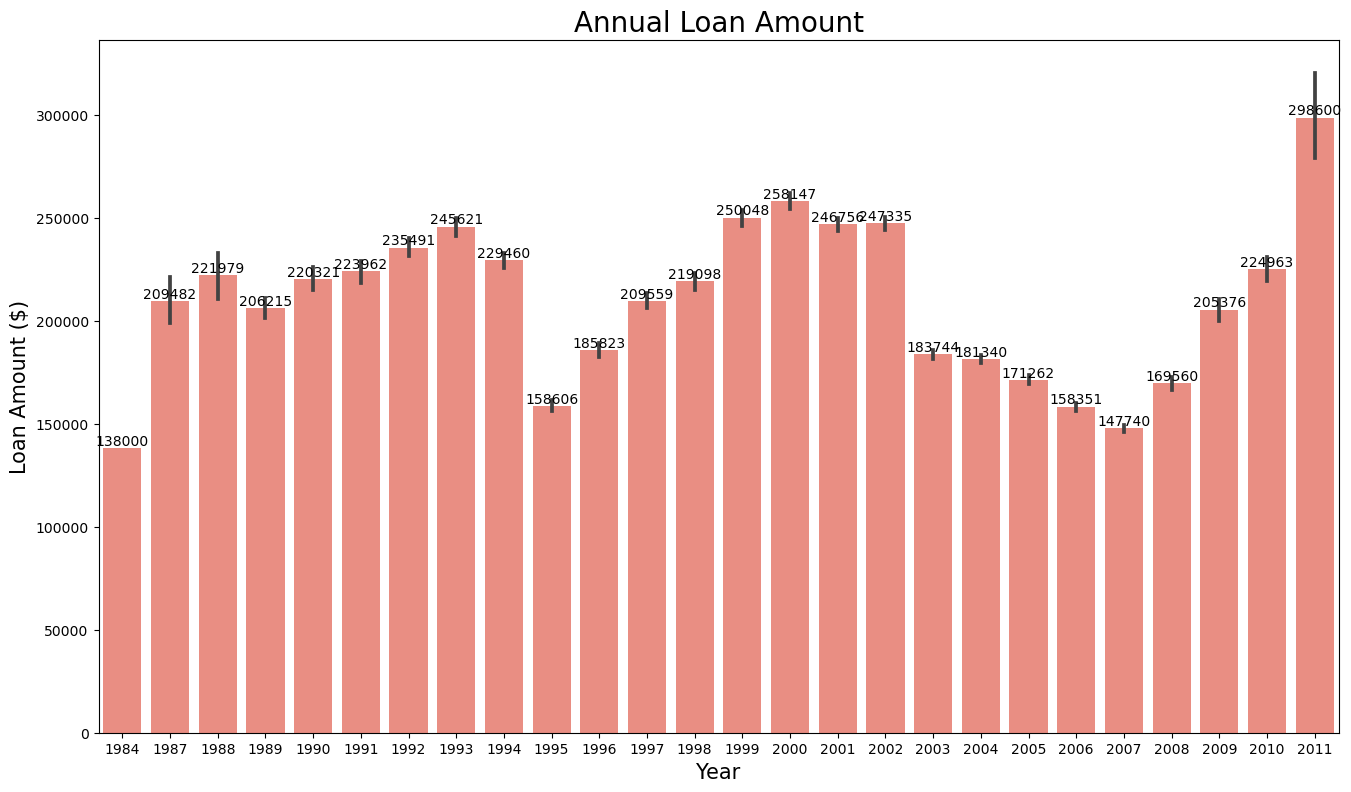

In [97]:
# Make a plot of the loan amount every year
f, ax = plt.subplots(figsize=(16,9))
sns_fig = sns.barplot(x="ApprovalFY", y="DisbursementGross", color='Salmon', data=data)

for i in sns_fig.containers:
    sns_fig.bar_label(i, )

plt.title('Annual Loan Amount', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Loan Amount ($)', fontsize=15)
plt.show()

In [98]:
data.DisbursementGross.describe()

count    6.533770e+05
mean     1.934851e+05
std      2.842418e+05
min      4.000000e+03
25%      3.750000e+04
50%      9.200000e+04
75%      2.200000e+05
max      1.144632e+07
Name: DisbursementGross, dtype: float64

The graph above is the number of loans that banks provide each year to entrepreneurs. It can be seen that there were several declines in 1994 and 2007. This was due to the global crisis in those years, so that banks would reduce loans to entrepreneurs. The average annual loan is $190,000–$200,000. Let's look in more detail by sector.

Text(0, 0.5, 'Sector Name')

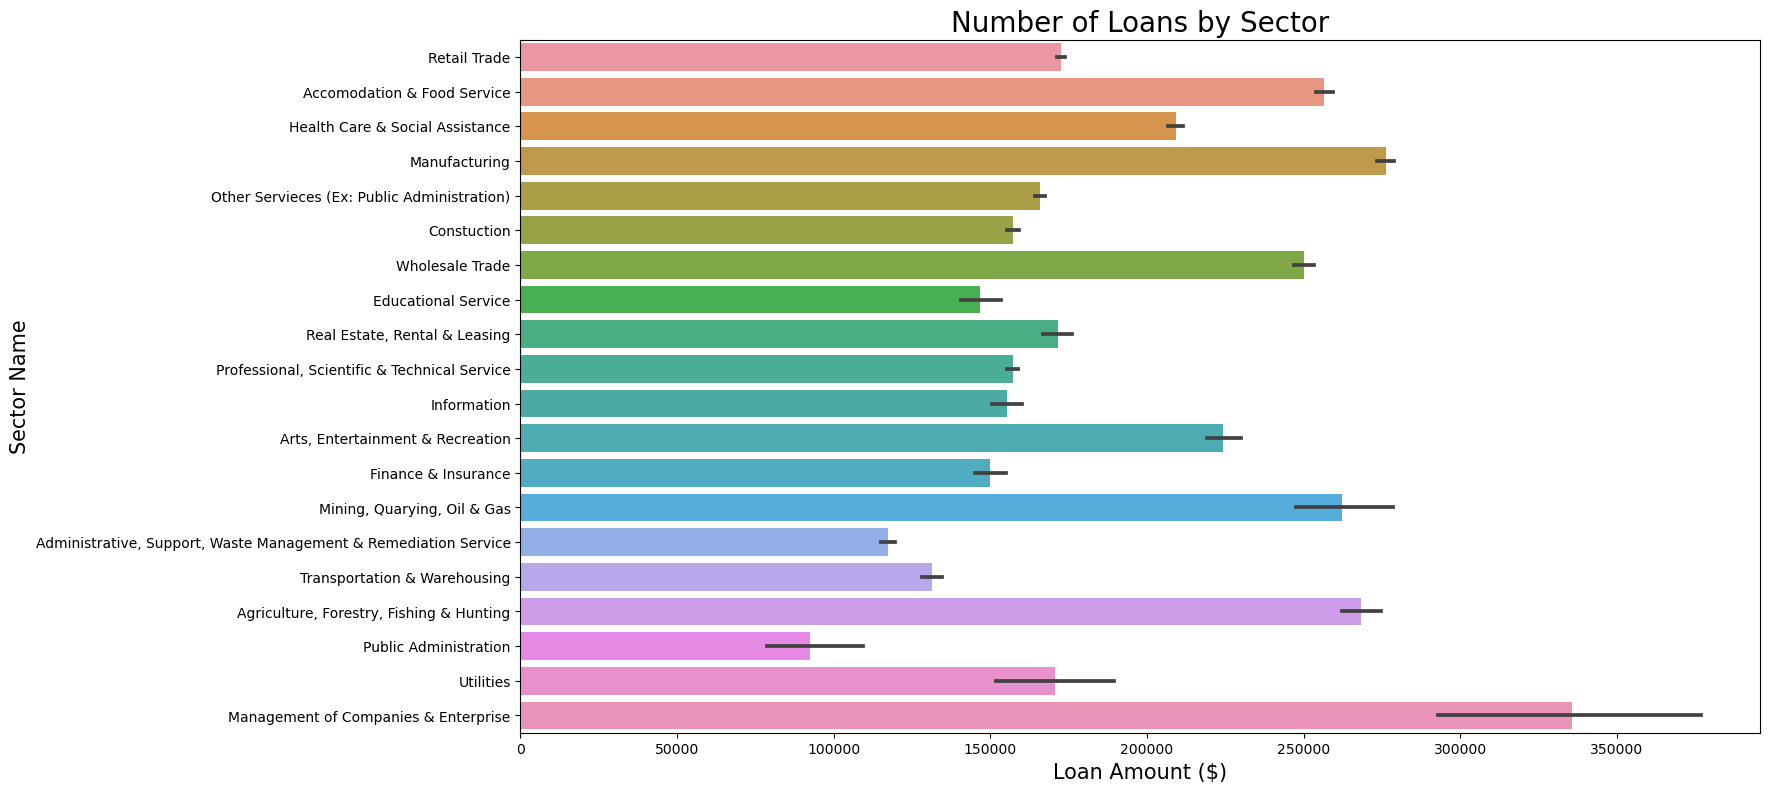

In [99]:
#Make a plot of the loan amount by sector
f, ax = plt.subplots(figsize=(16,9))
sns.barplot(x="DisbursementGross", y="Sector_name", data=data)
plt.title('Number of Loans by Sector', fontsize=20)
plt.xlabel('Loan Amount ($)', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)

In [102]:
data.groupby('Sector_name')['DisbursementGross'].describe().style.highlight_max(color='yellow').highlight_min(color='cyan')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accomodation & Food Service,64059.000000,256482.361136,354045.191225,4000.000000,50000.000000,130000.000000,285000.000000,5000000.000000
"Administrative, Support, Waste Management & Remediation Service",30189.000000,117252.122197,197300.466515,4000.000000,25000.000000,50000.000000,125000.000000,4656672.000000
"Agriculture, Forestry, Fishing & Hunting",8404.000000,268416.790814,288049.823996,4700.000000,60000.000000,168600.000000,384021.000000,2929780.000000
"Arts, Entertainment & Recreation",13808.000000,224344.170915,317524.797379,4000.000000,36909.250000,100000.000000,260000.000000,4426492.000000
Constuction,61622.000000,157278.581919,238484.059452,4000.000000,35000.000000,75000.000000,173682.500000,5658120.000000
Educational Service,5957.000000,146829.699513,251079.800795,4000.000000,25000.000000,52300.000000,150000.000000,2653000.000000
Finance & Insurance,8843.000000,149866.275020,235985.677122,4000.000000,30000.000000,66000.000000,150000.000000,2500000.000000
Health Care & Social Assistance,52021.000000,209244.256723,276016.311572,4000.000000,50000.000000,105000.000000,250000.000000,4000000.000000
Information,10634.000000,155157.020406,263323.367122,4024.000000,24100.000000,56933.000000,150000.000000,2200000.000000


As we can see from the graph and table above, the highest number of loan recipients is the Management Of Companies & Enterprise sector and the lowest is the Public Administration. The largest amount of data is in the Retail Trade sector and the least in the Public Administration sector, so that for further analysis the biggest and the smallest possibilities on each chart are these two sectors.

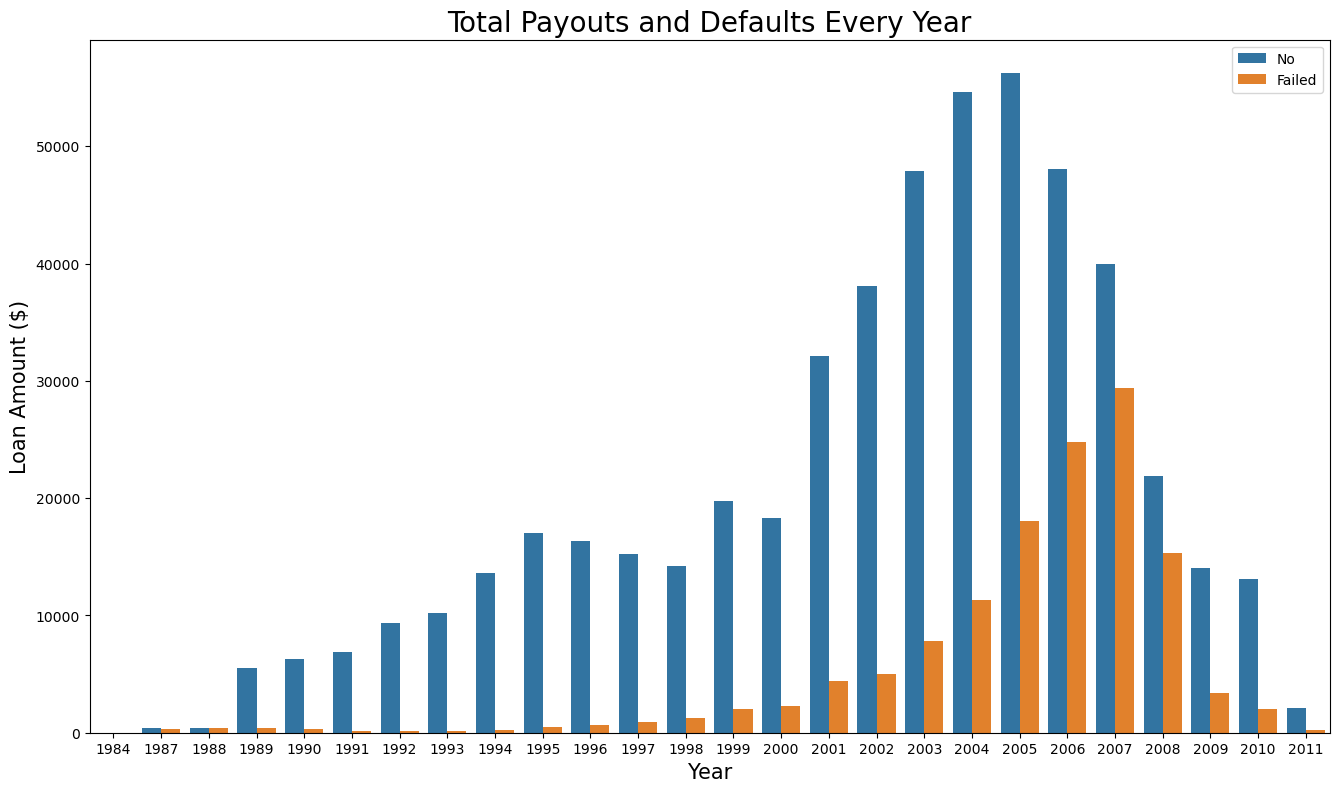

In [103]:
#View the amount paid and defaulted each year
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="ApprovalFY", data=data,hue='MIS_Status')
plt.title('Total Payouts and Defaults Every Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Loan Amount ($)', fontsize=15)
plt.legend(["No", "Failed"],loc='upper right')

We can see that there has been an increase in defaults starting in 2006-2008, this is in accordance with the state of the world economy at that time, which was experiencing a global recession, so that many entrepreneurs or businesses found it difficult to make payments.

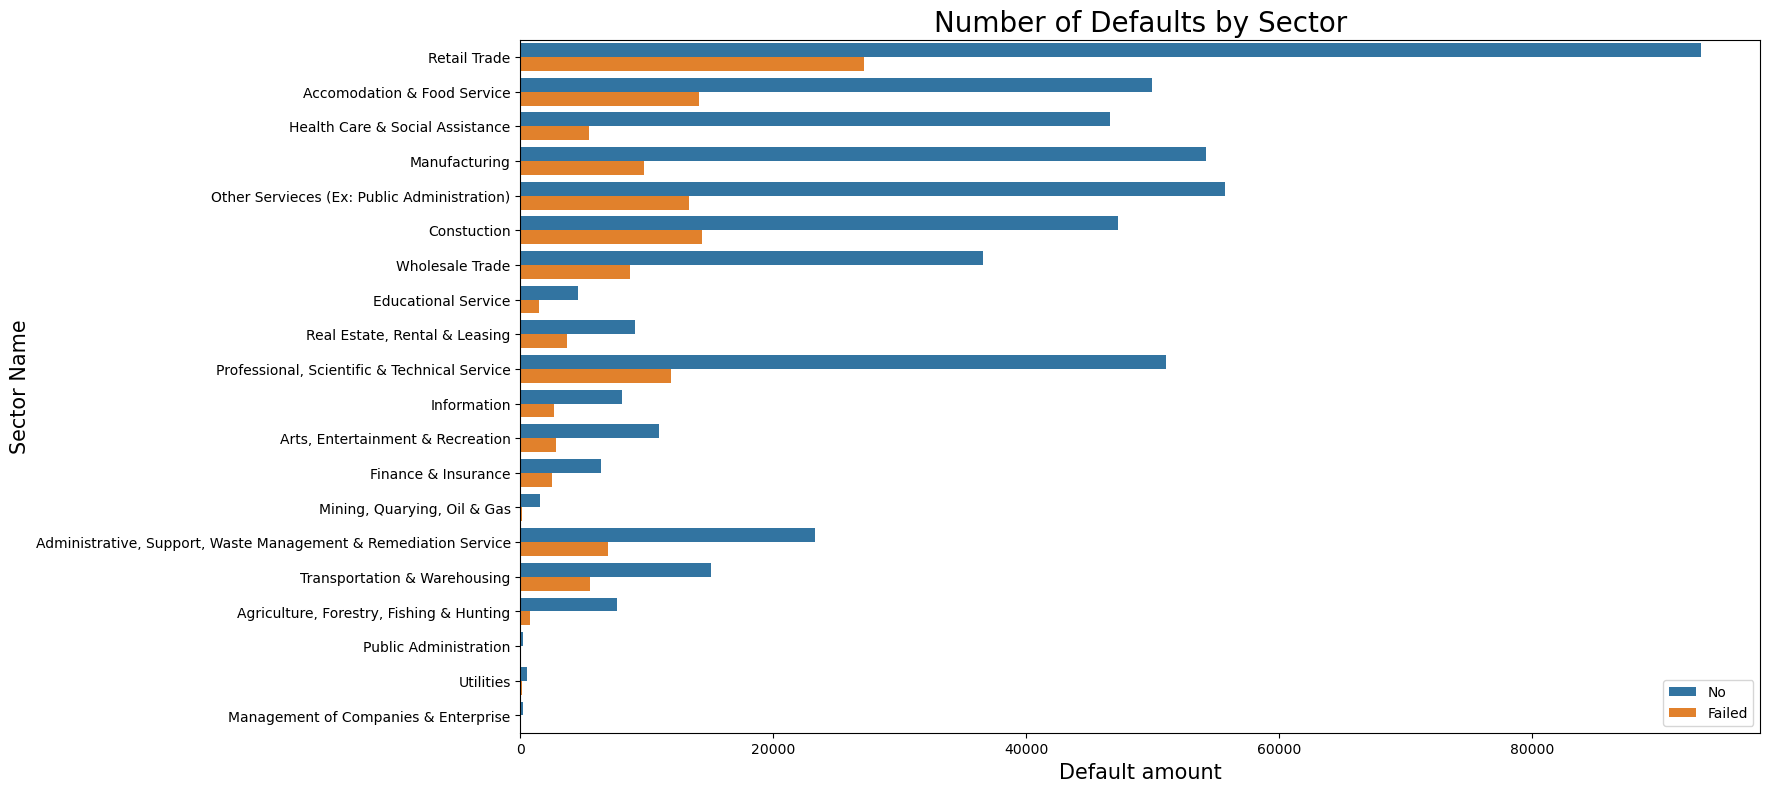

In [104]:
#See the amount paid & defaulted on each sector
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="MIS_Status", data=data)
plt.title('Number of Defaults by Sector', fontsize=20)
plt.xlabel('Default amount', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)
plt.legend(["No", "Failed"],loc='lower right')

In [105]:
pd.DataFrame(data.groupby('Sector_name')['MIS_Status'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='cyan')

As we know, the most data is Retail Trade, so the sector that has the most payments and defaults is this sector.

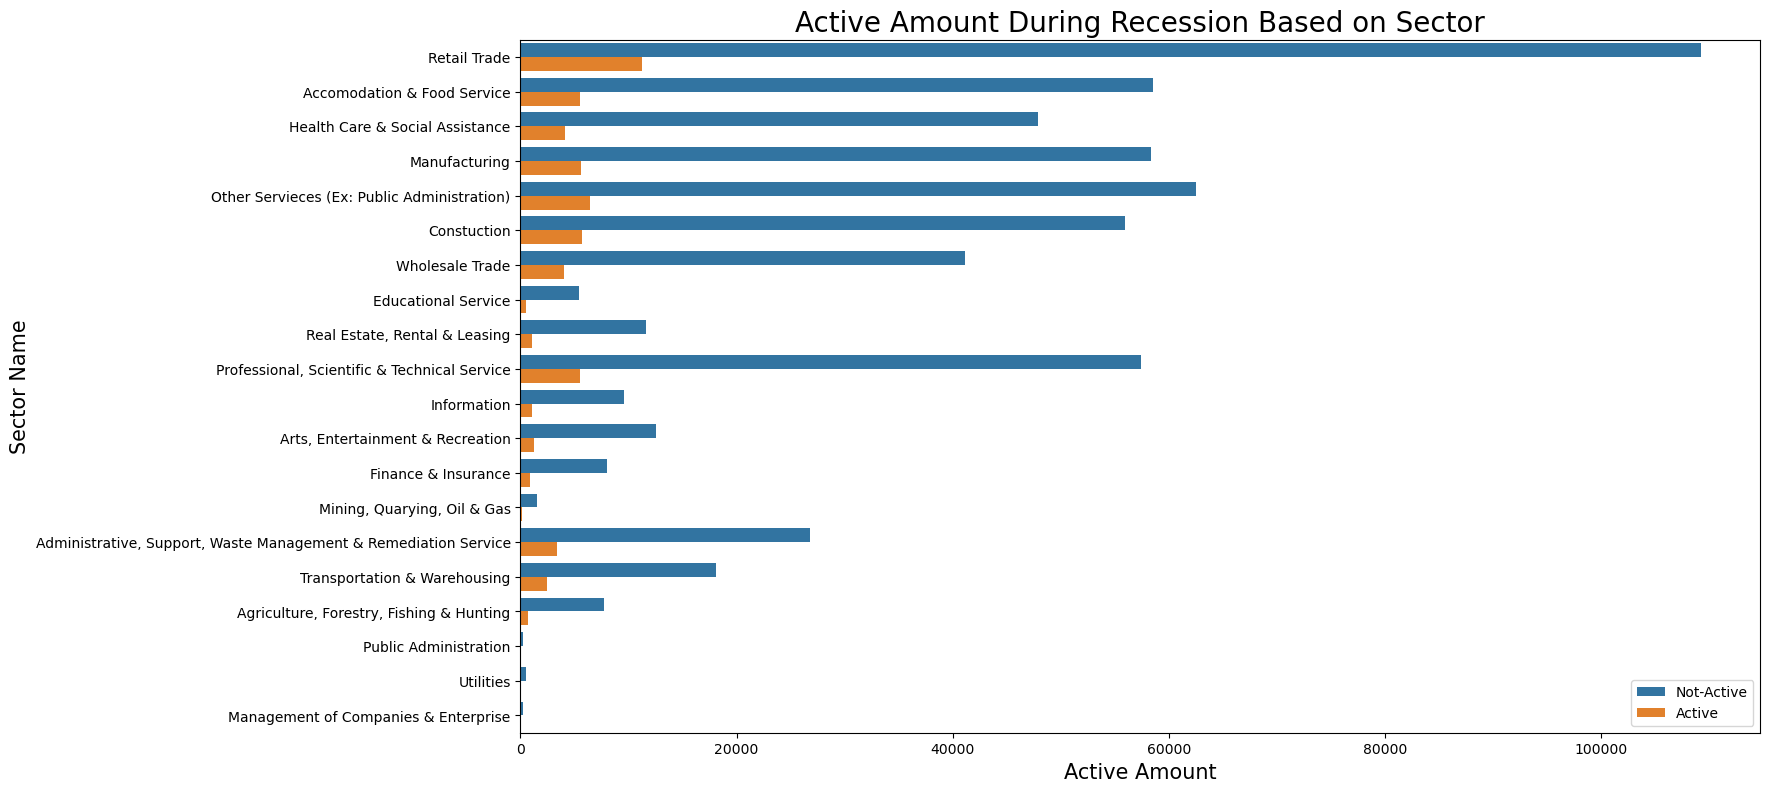

In [107]:
#Plot the active sectors during the 2008 global recession
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="Recession", data=data)
plt.title('Active Amount During Recession Based on Sector', fontsize=20)
plt.xlabel('Active Amount', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)
plt.legend(["Not-Active", "Active"],loc='lower right')
plt.show()

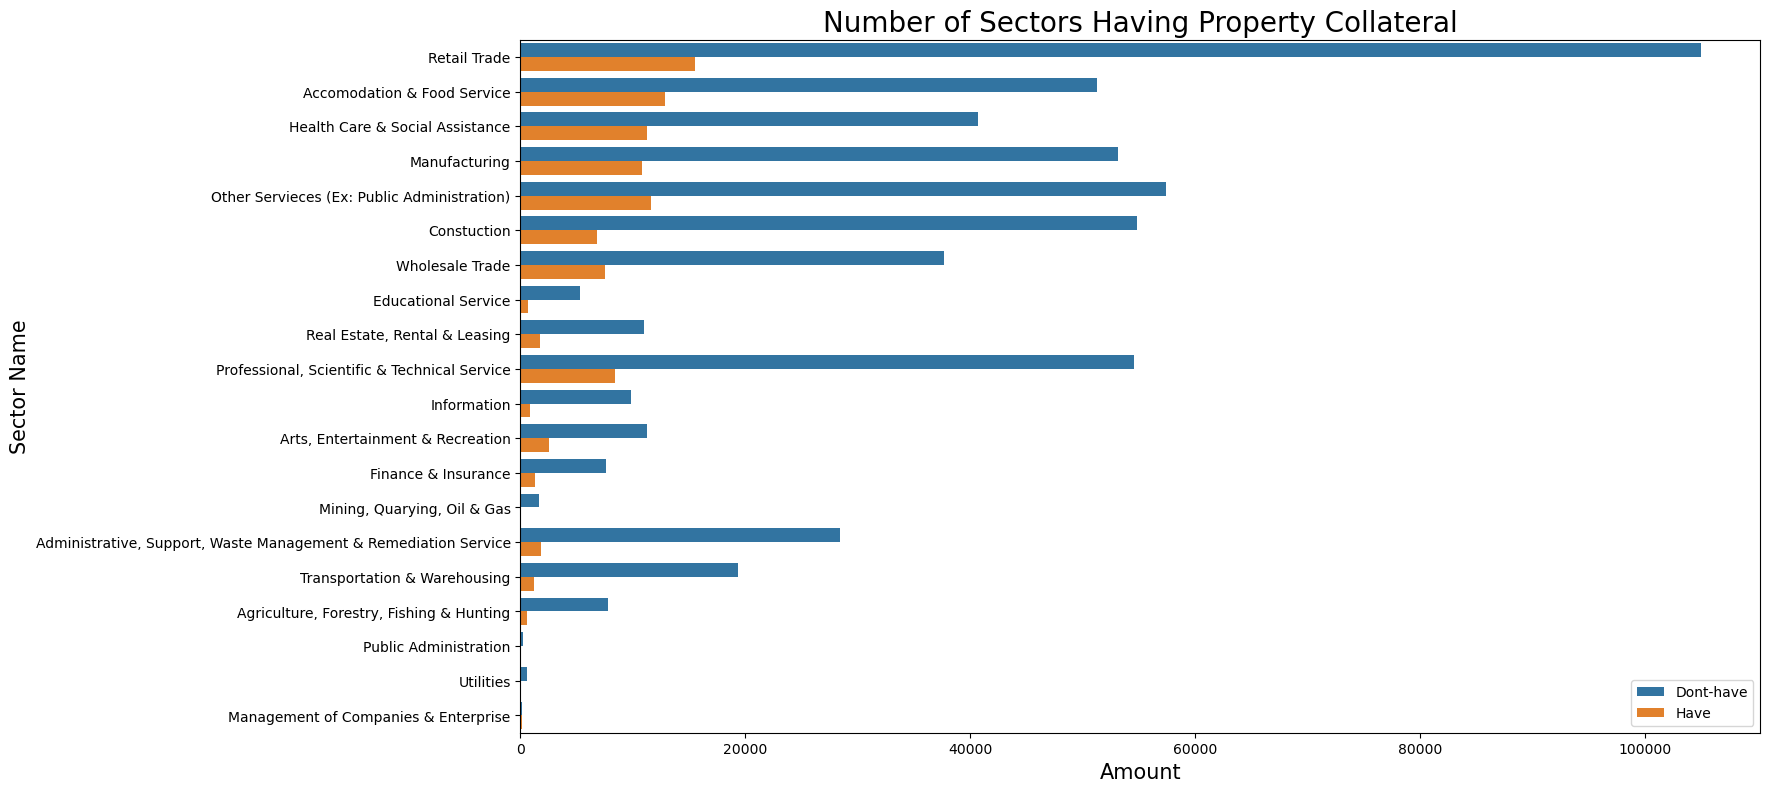

In [108]:
#Look at which sectors have property guarantees
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="RealEstate", data=data)
plt.title('Number of Sectors Having Property Collateral', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)
plt.legend(["Dont-have", "Have"],loc='lower right')
plt.show()

In [110]:
pd.DataFrame(data.groupby('Sector_name')['RealEstate'].value_counts()).unstack(level=1).style.highlight_max(color='yelow').highlight_min(color='cyan')

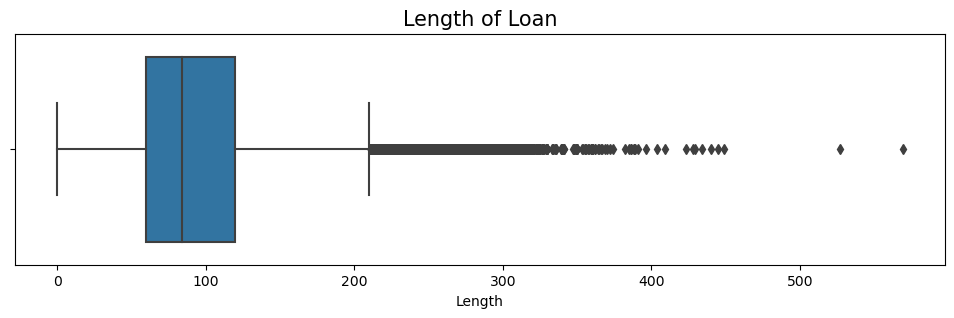

In [116]:
#See the length of the loan
f, ax = plt.subplots(figsize=(12,3))
sns.boxplot(data['Term'])
plt.title('Length of Loan', fontsize=15)
plt.xlabel('Length', fontsize=10)
plt.show()

In [117]:
#View loan details
data['Term'].describe() 

count    653377.000000
mean        104.191121
std          75.404780
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

Text(0, 0.5, 'Sector Name')

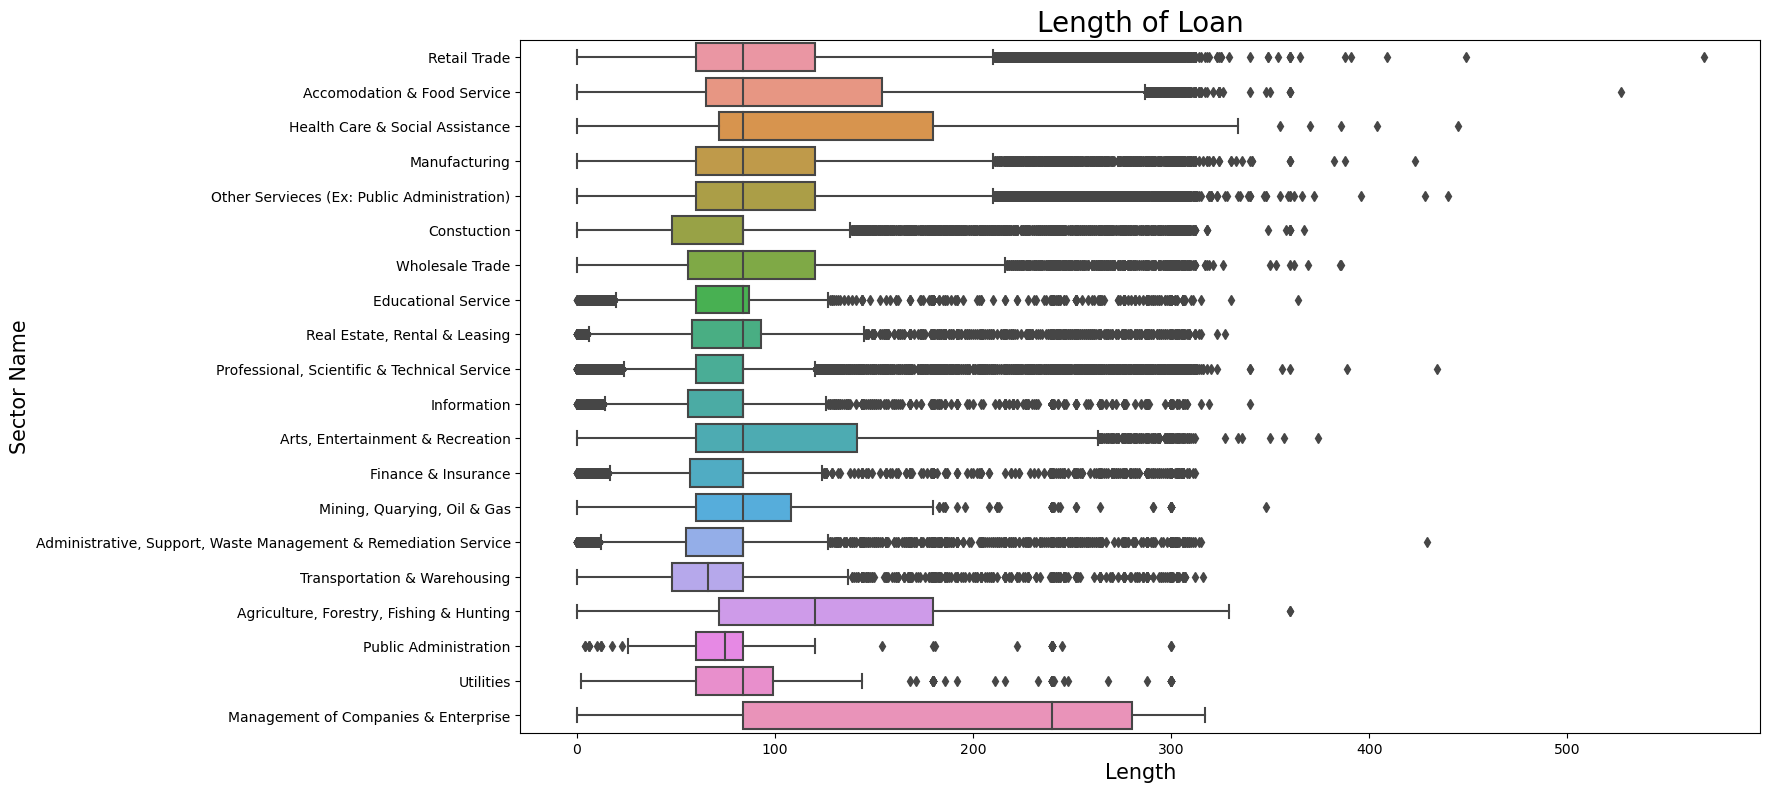

In [118]:
#See loans by sector
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x="Term", y="Sector_name", data=data)
plt.title('Length of Loan', fontsize=20)
plt.xlabel('Length', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)

In [119]:
#Loan details by sector
data.groupby('Sector_name')['Term'].describe().style.highlight_max(color='yellow').highlight_min(color='cyan')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accomodation & Food Service,64059.000000,120.668930,80.004442,0.000000,65.000000,84.000000,154.000000,527.000000
"Administrative, Support, Waste Management & Remediation Service",30189.000000,81.668687,55.197328,0.000000,55.000000,84.000000,84.000000,429.000000
"Agriculture, Forestry, Fishing & Hunting",8404.000000,119.735245,65.941232,0.000000,72.000000,120.000000,180.000000,360.000000
"Arts, Entertainment & Recreation",13808.000000,114.865151,77.241950,0.000000,60.000000,84.000000,141.250000,374.000000
Constuction,61622.000000,88.453848,71.232112,0.000000,48.000000,84.000000,84.000000,367.000000
Educational Service,5957.000000,95.106094,68.127575,0.000000,60.000000,84.000000,87.000000,364.000000
Finance & Insurance,8843.000000,97.702250,74.866735,0.000000,57.000000,84.000000,84.000000,312.000000
Health Care & Social Assistance,52021.000000,124.771438,82.270722,0.000000,72.000000,84.000000,180.000000,445.000000
Information,10634.000000,85.161275,60.284219,0.000000,56.000000,84.000000,84.000000,340.000000


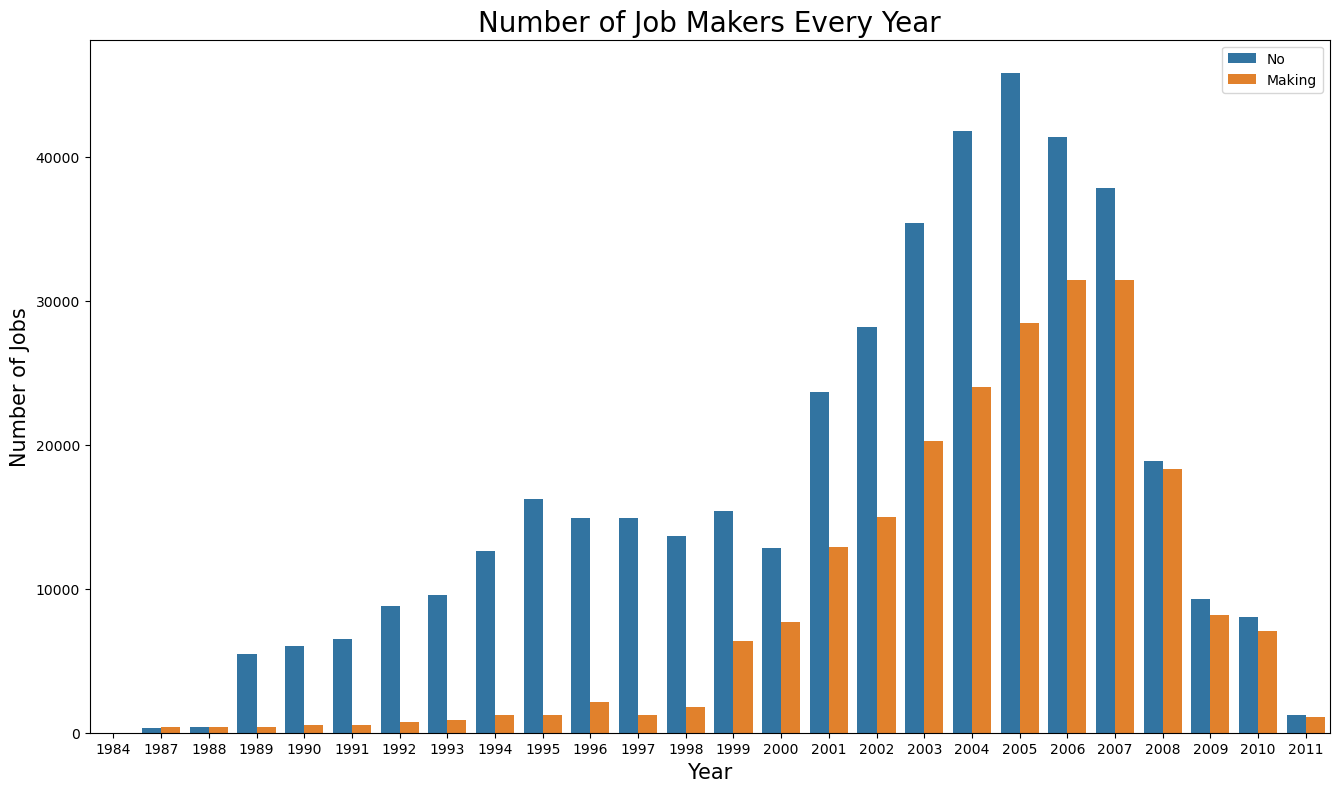

In [120]:
# Seeing the number of workers each year
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="ApprovalFY", data=data,hue='Is_CreatedJob')
plt.title('Number of Job Makers Every Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Jobs', fontsize=15)
plt.legend(["No", "Making"],loc='upper right')
plt.show()

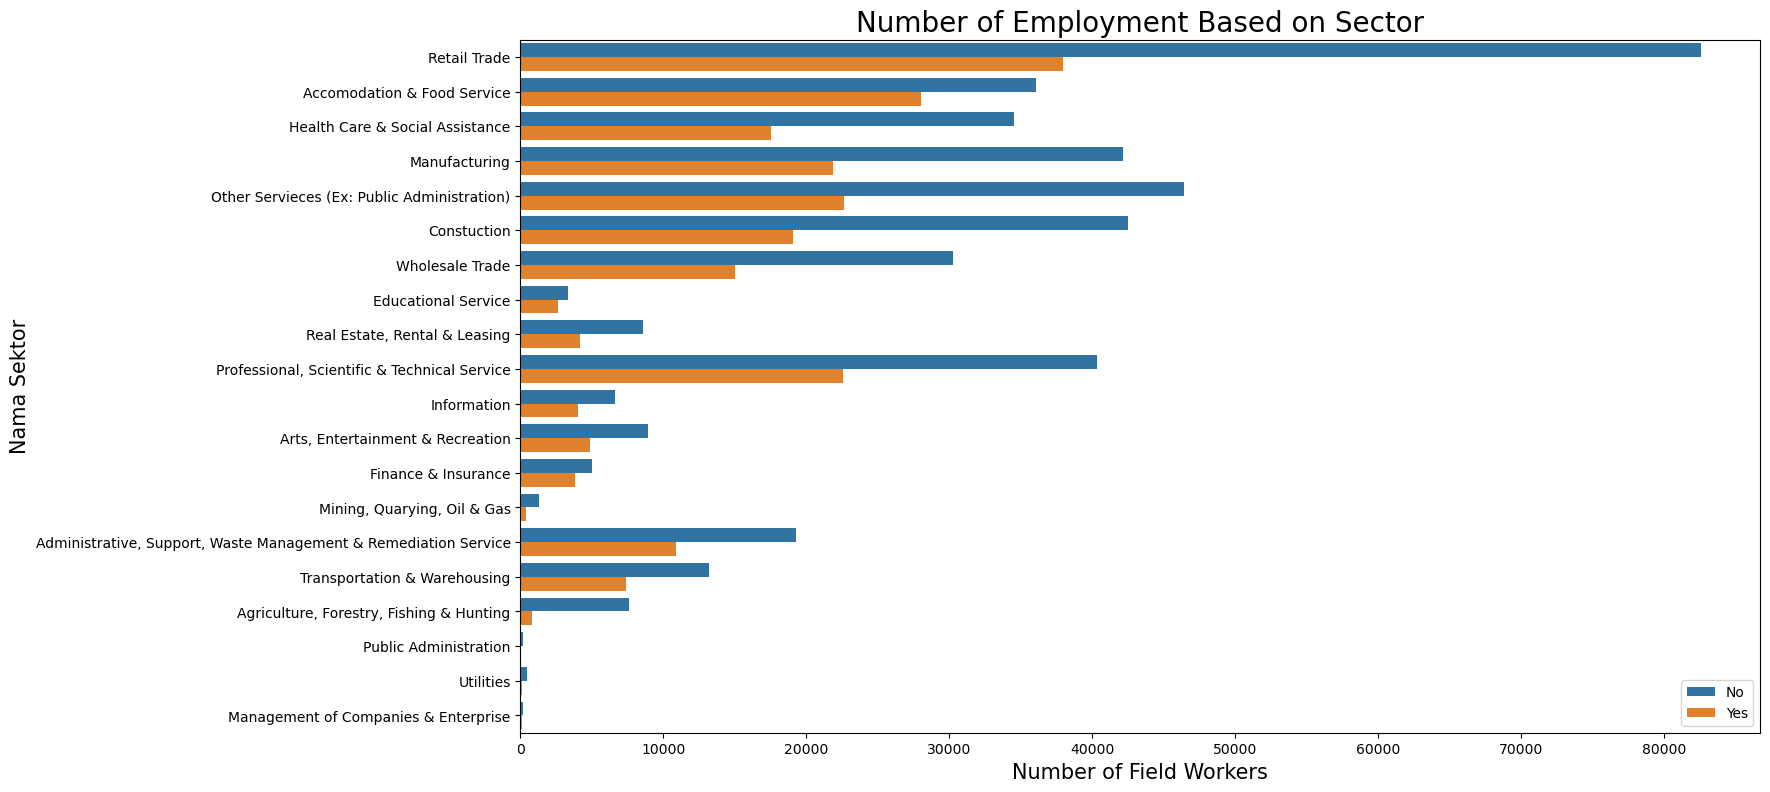

In [121]:
#Number of Employment fields by sector
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="Is_CreatedJob", data=data)
plt.title('Number of Employment Based on Sector', fontsize=20)
plt.xlabel('Number of Field Workers', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)
plt.legend(["No", "Yes"],loc='lower right')
plt.show()

In [122]:
#Detail Setiap sektor lapangan kerja
pd.DataFrame(data.groupby('Sector_name')['Is_CreatedJob'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='cyan')

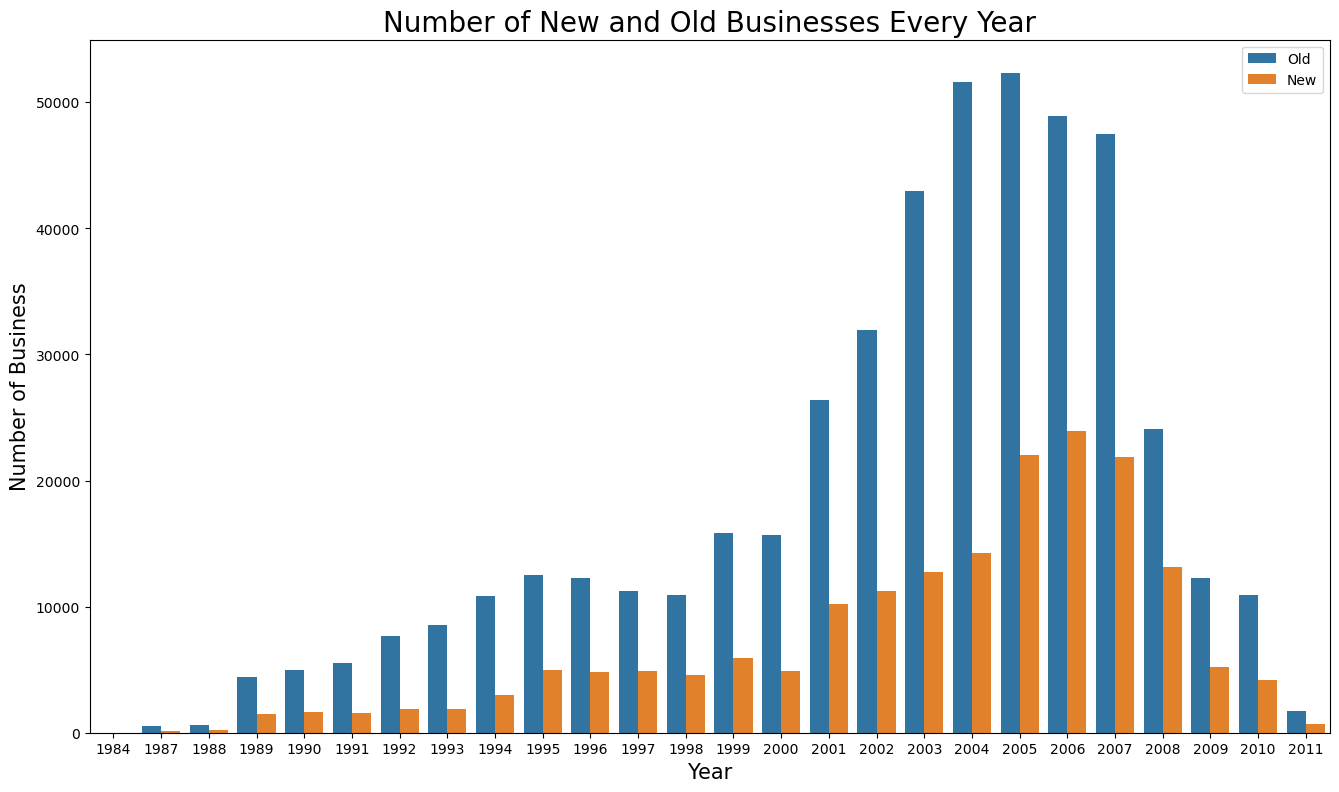

In [123]:
#See the number of new and existing businesses that join the SBA each year
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="ApprovalFY", data=data,hue='NewExist')
plt.title('Number of New and Old Businesses Every Year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Business', fontsize=15)
plt.legend(["Old", "New"],loc='upper right')
plt.show()

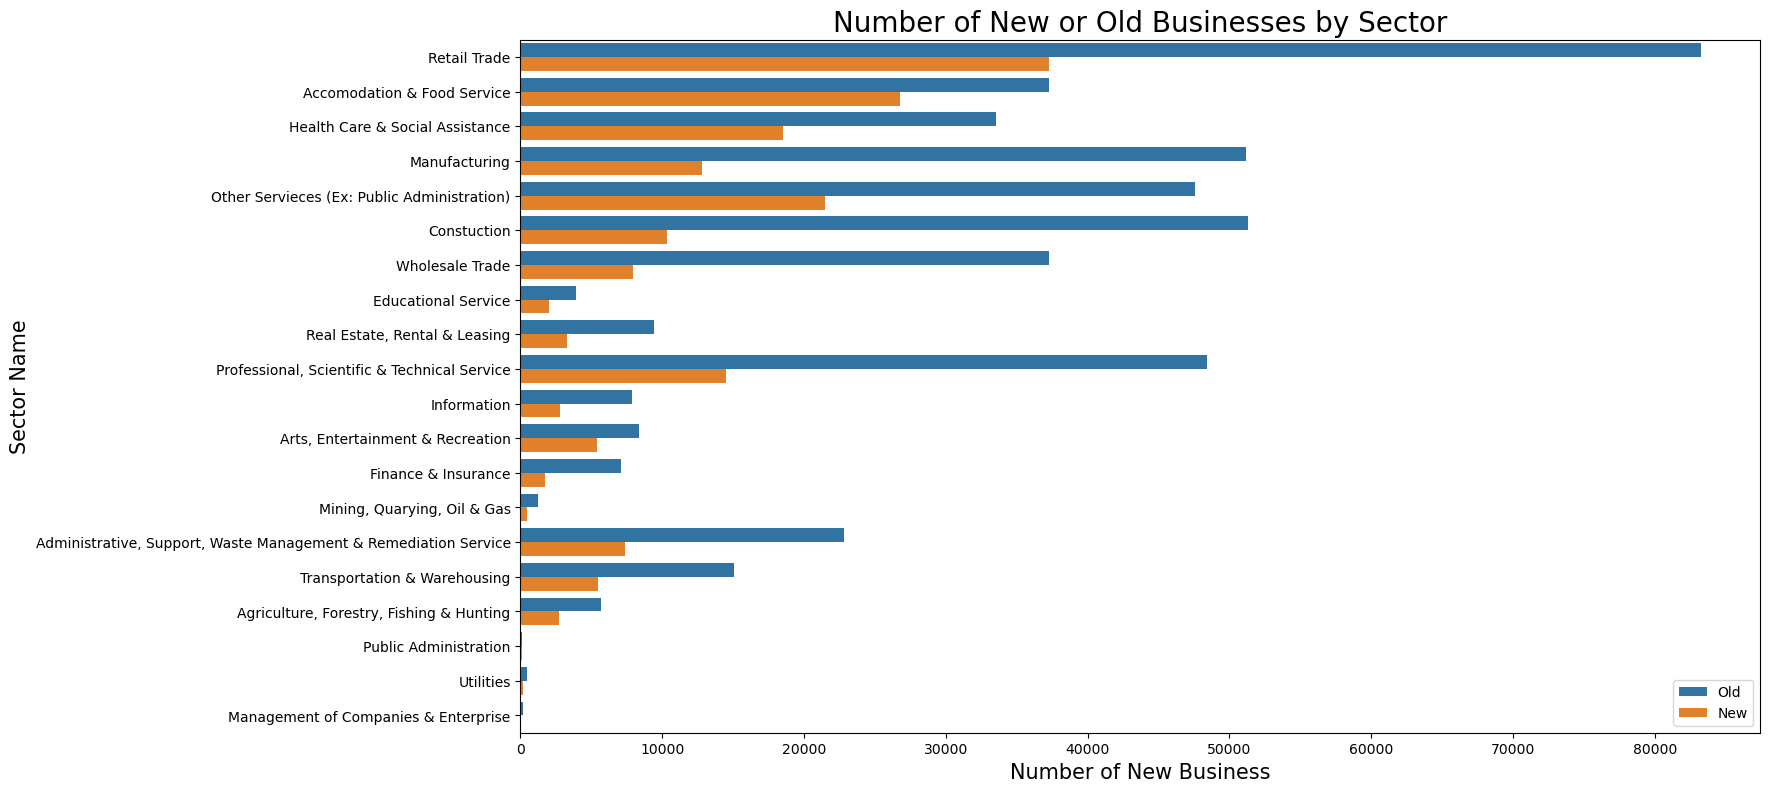

In [124]:
#Make a plot of the number of new and old businesses by sector
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="NewExist", data=data)
plt.title('Number of New or Old Businesses by Sector', fontsize=20)
plt.xlabel('Number of New Business', fontsize=15)
plt.ylabel('Sector Name', fontsize=15)
plt.legend(["Old", "New"],loc='lower right')

In [126]:
#Detail Jumla bisnis baru dan lama berdasarkn sektor
pd.DataFrame(data.groupby('Sector_name')['NewExist'].value_counts()).unstack(level=1).style.highlight_max(color='yellow').highlight_min(color='cyan')

##  **2.4 Handling Outliers**

We will see if there are any outliers in our data and we will try to handle them so there is no misinterpretation of our target variable. But we also need to check whether this outlier is wrong input or indeed it is an anomaly.

In [127]:
#we will remove columns that are considered unimportant
# column LoanNr_ChkDgt is not important because only the id of the borrower has been replaced with index
# City, State, UrbanRural and ZIP columns are unnecessary because we have changed them to state rate
# column bank and bank satet also not too important
# NAICS column has been replaced with Sector_rate
# the ApprovalDate and ApprovalFY columns because they are date only
# Term column removed because it has been replaced with RealEstate
# column UrbanRural because it doesn't affect the target
# column LowDoc because there is already a Gross Disbursement, LowDoc is only grouped administratively
# Active and DaysTerm columns because they have been replaced with Recession
# column ind_code because there is already a Secator_rate
# column ChgOffDate because it actually equals MIS_Status
# the DisbursementDate column because it's only the payment date
# column SBA_Appv because it has been replaced with Portion_SBA_Bank
# DisbursementDate field is deprecated
# column Sector_name has been deprecated
data = data.drop(axis =1, columns = ['LoanNr_ChkDgt','City','State', 'Zip', 'UrbanRural', 'LowDoc',
                                    'ApprovalDate', 'ApprovalFY', 'SBA_Appv','DisbursementDate', 
                                     'Sector_name','BalanceGross', 'ChgOffPrinGr'])

In [128]:
#We will use the Inter Quartile Range to deal with ouliers
#Determining Limits
def limit(i):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    # determine the usual upper limit and extreme upper limit
    lower_limit = data[i].quantile(0.25) - (IQR * 1.5)
    lower_limit_extreme = data[i].quantile(0.25) - (IQR * 3)
    upper_limit = data[i].quantile(0.75) + (IQR * 1.5)
    upper_limit_extreme = data[i].quantile(0.75) + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

#Calculate percent outliers from data   
def percent_outliers(i):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    # determine the usual upper limit and extreme upper limit
    lower_limit = data[i].quantile(0.25) - (IQR * 1.5)
    lower_limit_extreme = data[i].quantile(0.25) - (IQR * 3)
    upper_limit = data[i].quantile(0.75) + (IQR * 1.5)
    upper_limit_extreme = data[i].quantile(0.75) + (IQR * 3)
    
    # see the percentage of outliers to the total data
    print('Lower Limit: {} %'.format(data[(data[i] >= lower_limit)].shape[0]/ data.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(data[(data[i] >= lower_limit_extreme)].shape[0]/data.shape[0]*100))
    print('Upper Limit: {} %'.format(data[(data[i] >= upper_limit)].shape[0]/ data.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(data[(data[i] >= upper_limit_extreme)].shape[0]/data.shape[0]*100))

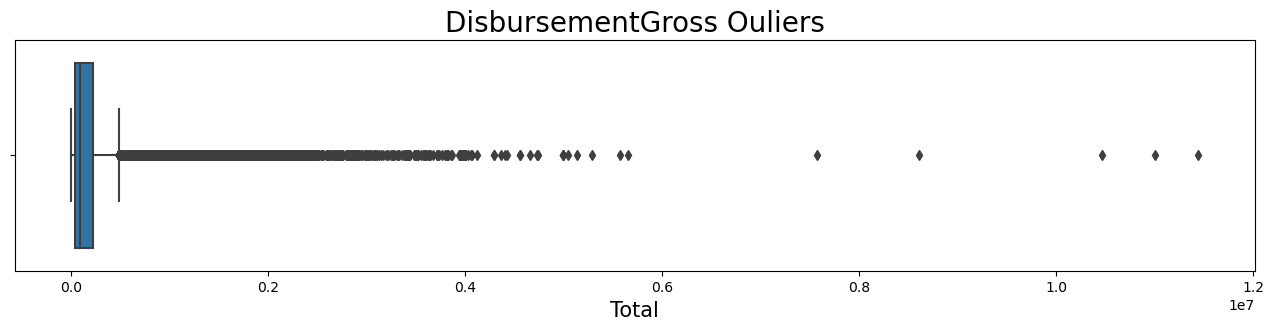

In [131]:
#Let's check the DisbursementGross column
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['DisbursementGross'])
plt.title('DisbursementGross Ouliers', fontsize=20)
plt.xlabel('Total', fontsize=15)
plt.show()

In [132]:
#we will check the limit outliers and what percentage of our data exceeds the limit
print(limit('DisbursementGross'))
print('-'*50)
print(percent_outliers('DisbursementGross'))

Lower Limit: -236250.0
Lower Limit Extreme: -510000.0
Upper Limit: 493750.0
Upper Limit Extreme: 767500.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 10.37701051613387 %
Upper Limit Extereme: 4.92533407205947 %
None


In [133]:
#because there are 10% of the amount of data we have, so I try to change the data by using
#log transformation, because if the ouliers are removed a lot of data is lost (10%)
data['DisbursementGross'] = np.log(data['DisbursementGross'])
data['DisbursementGross'].skew()

-0.00882132833702303

In [134]:
#we will check the limit outliers and what percentage of our data exceeds the limit
print(limit('DisbursementGross'))
print('-'*50)
print(percent_outliers('DisbursementGross'))

Lower Limit: 7.878166291894507
Lower Limit Extreme: 5.2242363718305125
Upper Limit: 14.955312745398492
Upper Limit Extreme: 17.60924266546249
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.01591730348634862 %
Upper Limit Extereme: 0.0 %
None


In [135]:
#it turns out that there are still around 1% outliers, because the number is relatively small, so we just drop them
outliers1_drop = data[(data['DisbursementGross'] > 14.9)].index
data.drop(outliers1_drop, inplace=True)

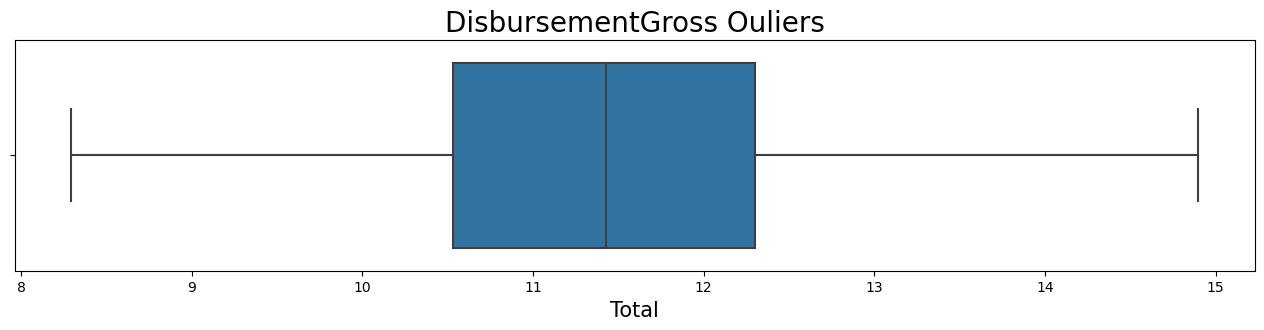

In [136]:
#Let's check again if there are any outliers
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['DisbursementGross'])
plt.title('DisbursementGross Ouliers', fontsize=20)
plt.xlabel('Total', fontsize=15)
plt.show()

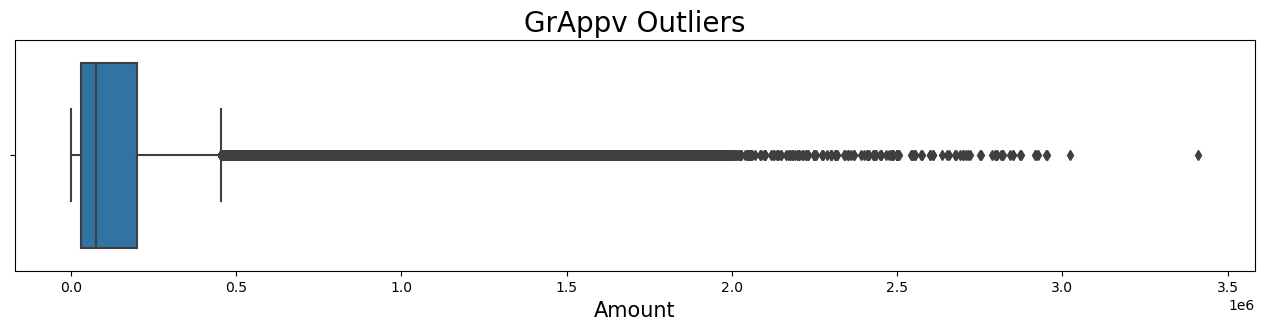

In [137]:
#Let's check the GrAppv column for outliers
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['GrAppv'])
plt.title('GrAppv Outliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.show()

In [138]:
#we will check the limit outliers and what percentage of our data exceeds the limit
print(limit('GrAppv'))
print('-'*50)
print(percent_outliers('GrAppv'))

Lower Limit: -225000.0
Lower Limit Extreme: -480000.0
Upper Limit: 455000.0
Upper Limit Extreme: 710000.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 10.87848046622059 %
Upper Limit Extereme: 5.636101173664721 %
None


In [139]:
data['GrAppv'] = np.log(data['GrAppv'])
data['GrAppv'].skew()

0.08156290058763929

In [140]:
#we will check the limit outliers and what percentage of our data exceeds the limit
print(limit('GrAppv'))
print('-'*50)
print(percent_outliers('GrAppv'))

Lower Limit: 7.463272683315471
Lower Limit Extreme: 4.617592705986649
Upper Limit: 15.051752622858995
Upper Limit Extreme: 17.89743260018782
None
--------------------------------------------------
Lower Limit: 99.98974363684513 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


In [141]:
#it turns out that there are still around 1% outliers, because the number is relatively small, so we just drop them
outliers2_drop = data[(data['GrAppv'] < 7.5)].index
data.drop(outliers2_drop, inplace=True)

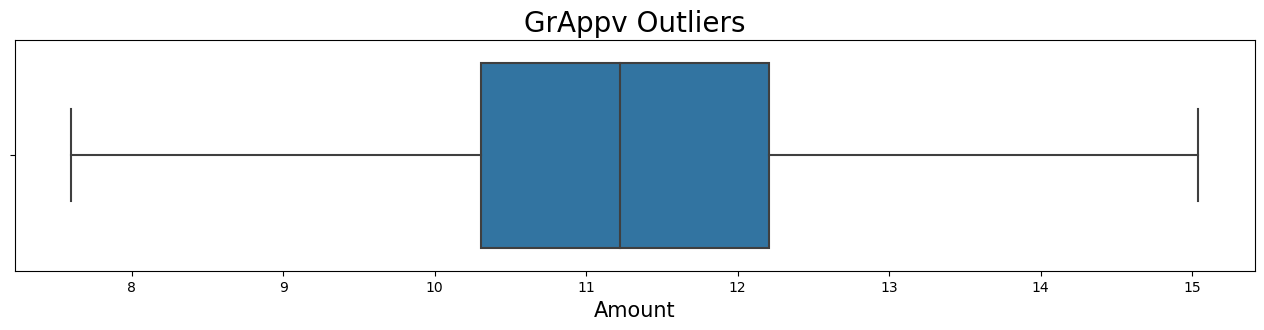

In [142]:
#Let's check again on the GrAppv column if there are still outliers
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['GrAppv'])
plt.title('GrAppv Outliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.show()

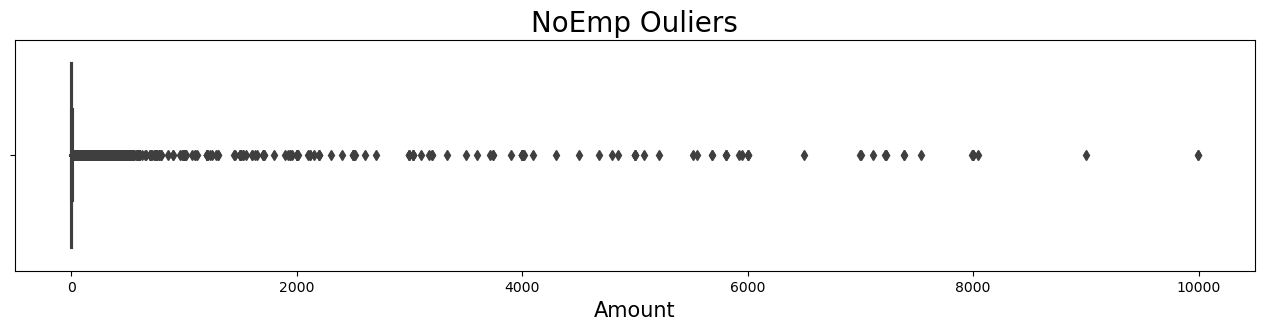

In [143]:
#we check the ouliers in the NoEmp column
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['NoEmp'])
plt.title('NoEmp Ouliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.show()

In [144]:
#we will check the limit outliers and what percentage of our data exceeds the limit
print(limit('NoEmp'))
print('-'*50)
print(percent_outliers('NoEmp'))

Lower Limit: -8.5
Lower Limit Extreme: -19.0
Upper Limit: 19.5
Upper Limit Extreme: 30.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 11.150728888861671 %
Upper Limit Extereme: 6.306779385963569 %
None


In [145]:
# in the NoEmp column, there is input 0, I will consider this an error, input, because it cannot be a company
# have no employees
wrong_input = data[(data['NoEmp'] == 0)].index
data.drop(wrong_input, inplace=True)

In [146]:
#do the boxcox transformation because I have tried all the methods but this is the best result
data['NoEmp']= stats.boxcox(data['NoEmp'])[0]

In [147]:
data['NoEmp'].skew()

0.06759585084383528

In [148]:
#we will check again the limit of outliers and what percentage of our data exceeds the limit
print(limit('NoEmp'))
print('-'*50)
print(percent_outliers('NoEmp'))

Lower Limit: -0.9934898228525592
Lower Limit Extreme: -2.6285364907190836
Upper Limit: 3.366634624791506
Upper Limit Extreme: 5.00168129265803
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.029782250087572158 %
Upper Limit Extereme: 0.0 %
None


In [149]:
#it turns out that there are still around 0.02% outliers, because the numbers are relatively small, so we just drop them
outliers3_drop = data[(data['NoEmp'] > 3.3)].index
data.drop(outliers3_drop, inplace=True)

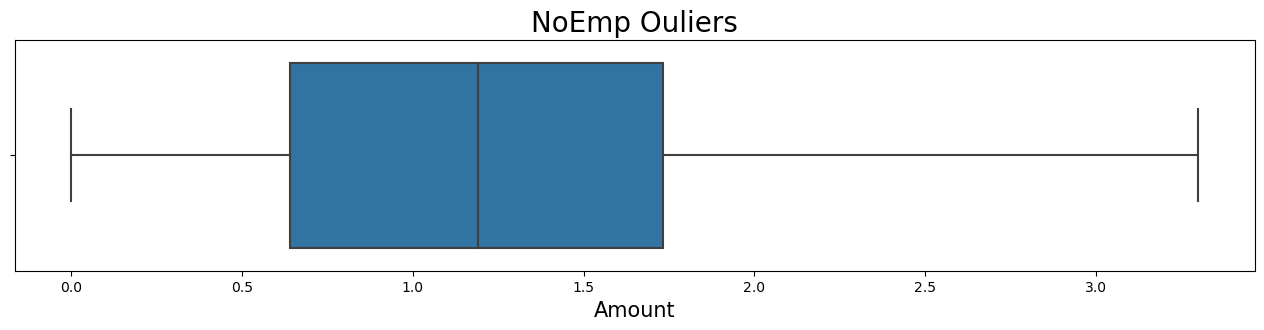

In [150]:
#we check the ouliers again in the NoEmp column
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['NoEmp'])
plt.title('NoEmp Ouliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.show()

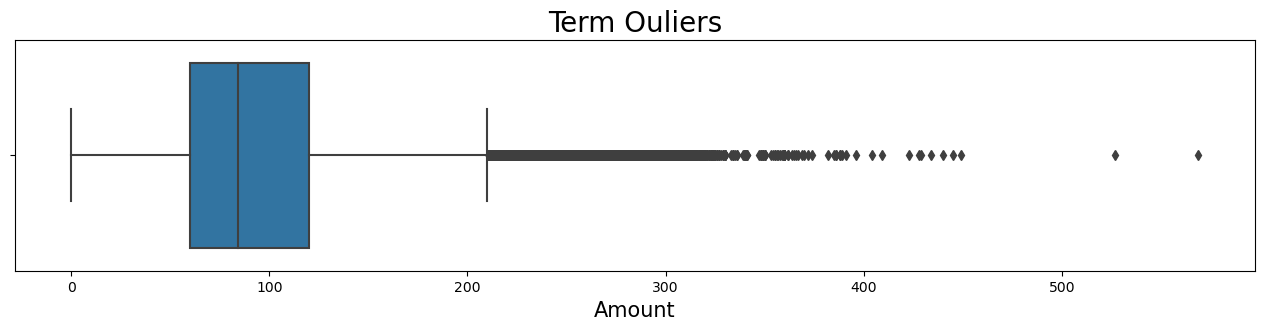

In [151]:
#we check ouliers in the Term column
f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['Term'])
plt.title('Term Ouliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.show()

In [152]:
#Because there is data that the old loan is 0 months and 43 years
#because there can be no time 0 and 569 months (43 years)
#while we only have data collection from 1987–2010 (23 years),
# up to a minimum of 5 years (75 months) or a maximum of 23 years (276 months)

wrong_input_2 = data[(data['Term'] < 75)].index
wrong_input_3 = data[(data['Term'] > 276)].index
data.drop(wrong_input_2, inplace=True)
data.drop(wrong_input_3, inplace=True)

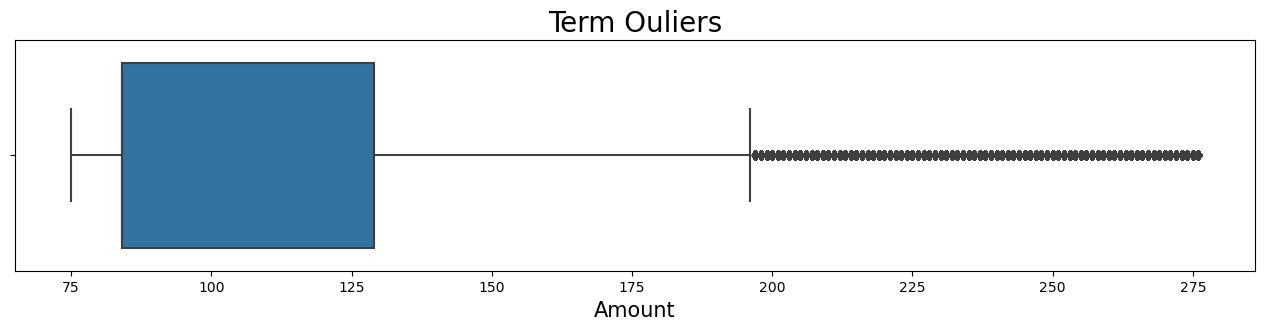

In [153]:
#we check the ouliers again in the Term column

f, ax = plt.subplots(figsize=(16,3))
sns.boxplot(x=data['Term'])
plt.title('Term Ouliers', fontsize=20)
plt.xlabel('Amount', fontsize=15)
plt.show()

In [154]:
#we will check again the limit of outliers and what percentage of our data exceeds the limit

print(limit('Term'))
print('-'*50)
print(percent_outliers('Term'))

Lower Limit: 16.5
Lower Limit Extreme: -51.0
Upper Limit: 196.5
Upper Limit Extreme: 264.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 18.04674333954958 %
Upper Limit Extereme: 1.0713776289166301 %
None


In [155]:
#we will not drop this outlier, because apart from the large number (18%) this is not necessarily an incorrect input, because it is
#some industries can take long loan terms such as oil & gas or mining

## **2.5 Feature Selection**

At this stage we will choose or look for which features are most relevant to our target. I have tried using KBest and Feature Importance and I also don't use the correlation coefficient because of the target variable and there are several categorical independent variables. However, after being included in the best model is Fetaure Importance.

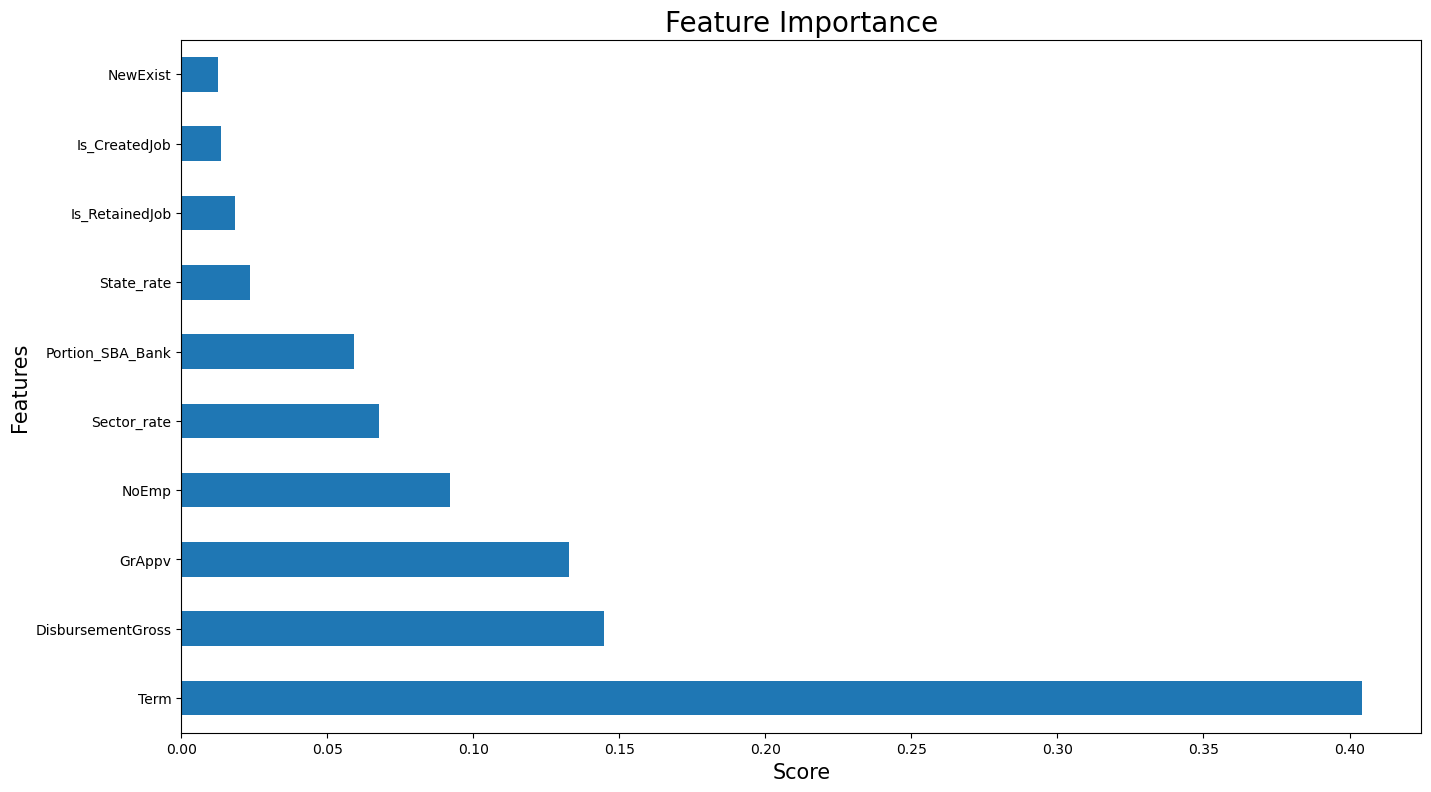

In [156]:
#because the data has a very large number of inputs, I will use the feature importance technique in fetaure selection
#we will first separate the independent and dependent features
#data = data.reset_index(drop=True) #reset index first so index is sorted
y = data['MIS_Status']
X = data.drop(columns=['MIS_Status'], axis=1)

#Let's try using fetaure importance on the RandomForestClassifier model
model = RandomForestClassifier()
model.fit(X,y)

#We visualize important features
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
f, ax = plt.subplots(figsize=(16,9))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.show()

It can be seen that these are the 10 variables that have an impact on our target:
1. Term (Language Length) = very reasonable, this is the highest because if a company borrows for a long period of time, the possibility of repaying it will be greater because the interest given will be smaller, making it easier for the company to pay it and financial stability economic impact both nationally and internationally which does not really have an impact which ultimately makes the company reduce the possibility of default.


2. RevLineCr = Revolving Line of credit, this is when you have borrowed and then borrowed again. It can be said that if he can do Revolving then the bank has judged that this company is capable of repaying the loan so that it is given another loan. So if this company Revolving Line Of Credit also makes the company less likely to default.


3. Portion_SBA_Bank = This is how much SBA dares to guarantee the loan provided by the Bank. The greater the percentage, the SBA is automatically confident enough with the company not to default on payments.


4. Is_RetainedJob = Does the company have permanent employees? Because if not, it is likely that the company is not stable because it has not been able to have permanent employees. If it is not stable, then the possibility to maximize the business is also not yet, thereby increasing the possibility of default.


5. Disbursement Gross = It is also an important factor because the amount of the loan paid is whether there is a penalty or according to the initial loan, if it is more then there is a possibility of a penalty.


6. State_rate = Keep in mind that the policy for each region is different and this is also calculated by the average number of defaults in each region from all sectors, so the higher it is, the more likely it is to default.


7. GrAppv = Represents the amount of the loan provided by the bank. We cannot see this from only one side because the bank also has its own size.


8. Recssion = If he is active during hard times such as a recession, then the possibility of his business is stable, because even during susas he remains active, so the possibility of default is smaller.


9. Sector_rate = just like the State rate, each sector also has its own default rate or percentage of probability of default. Because it is impossible to compare it to the oil & gas sector, mining is equated with Retail Trade because the risks and stability of the business are different.


10. Is_CreatedJob = Opening up jobs is also a consideration because by opening up jobs it can be seen that the company is developing operationally with an increase in recruited employees, so if the company develops it will reduce the possibility of default.


It should be noted that all of these variables cannot be seen only from one side, but there is a relationship between variables. Because my background is not a banking, economist or finance, I will analyze this based on the logic and guidelines provided by the SBA. There needs to be someone from the business domain who is better able to explain these variables to the probability of default.

In [157]:
#Based on the feature selection above, we will select those features and discard the
#features that are irrelevant to the target
data = data[['RevLineCr', 'Term', 'Portion_SBA_Bank', 'GrAppv', 'State_rate', 'DisbursementGross',
            'Is_RetainedJob', 'Sector_rate', 'Recession', 'Is_CreatedJob', 'MIS_Status']]
data.shape

(378578, 11)

 ## **2.6 Imbalance Dataset**
 
Because this is a classification problem and the target variable in the dataset that we have is a very far comparison because the percentage that fails to pay is definitely less than that which succeeds, so we need to handle this so that when we enter the model there is no bias due to differences. ratio to the target variable.

In [158]:
#We check the variable target ratio
print(data.MIS_Status.value_counts())
print('-'*50)
print('MIS_Status (0): {} %'.format(data[(data['MIS_Status'] == 0)].shape[0]/data.shape[0]*100))
print('MIS_Status (1): {} %'.format(data[(data['MIS_Status'] == 1)].shape[0]/data.shape[0]*100))

0    357073
1     21505
Name: MIS_Status, dtype: int64
--------------------------------------------------
MIS_Status (0): 94.31953256660451 %
MIS_Status (1): 5.680467433395496 %


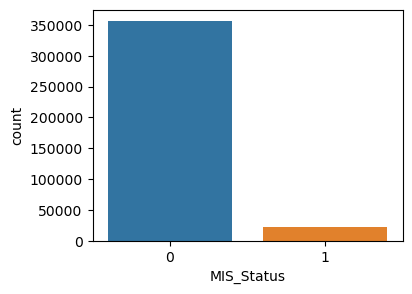

In [163]:
#Visualization of Imbalance Dataset Before Fixing
plt.figure(figsize=(4,3))
sns.countplot("MIS_Status",data=data)
plt.show()

it can be seen that our target variable is imbalanced, 0 (Not Default): 94.3% and 1(Default): 5.7% so we will deal with this problem, because otherwise the model will be more likely to predict 0 because there are more in the number

In [164]:
#first we will divide the data into train and test, but keep in mind, if our target data is imbalance
#so that we divide the data in the train and test it must be appropriate, so there may not be any data sharing
#only contains 0 or the majority, that's why we use stratify=y
y = data['MIS_Status']
X = data.drop(columns=['MIS_Status'], axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=27, stratify=y) #don't forget to stratify

In [165]:
#Here I use SMOTE and then undersampling again
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

#now we are fit to our training data
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# **3. Modelling**

After all the data is clean and ready to be entered into the model, then it's time for us to make a model and look for the most consistent model. Here I immediately evaluate after making a model, trained and tested it to make it easier to see which model is the most optimal.

In [166]:
# Create a function that can later be trained and tested and then evaluated
def model_eval(algo,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_train_ypred = algo.predict(X_train)
    y_train_prob = algo.predict_proba(X_train)[:,-1]

    #TEST

    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:,-1]
    y_probas = algo.predict_proba(X_test)
    
    #Confussion Matrix
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    #ROC Curve
    #fpr,tpr,thresholds = roc_curve(y_test,y_test_prob)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #PR Curve
    skplt.metrics.plot_precision_recall(y_test, y_probas)
    plt.show()

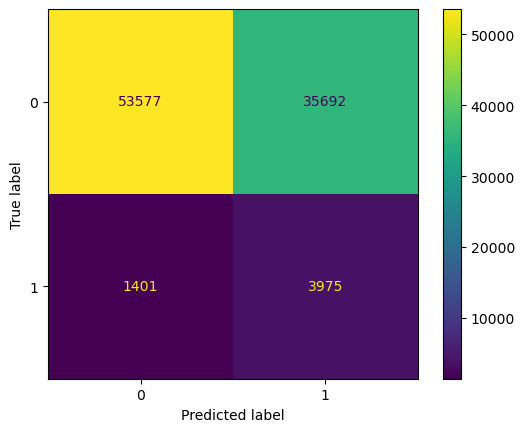

Classification Report: 
               precision    recall  f1-score   support

           0      0.975     0.600     0.743     89269
           1      0.100     0.739     0.176      5376

    accuracy                          0.608     94645
   macro avg      0.537     0.670     0.460     94645
weighted avg      0.925     0.608     0.711     94645



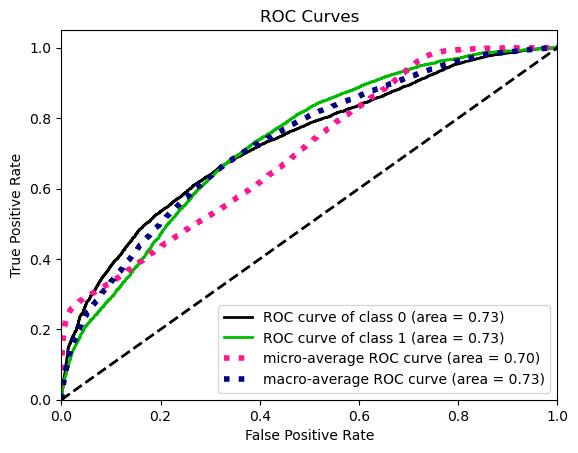

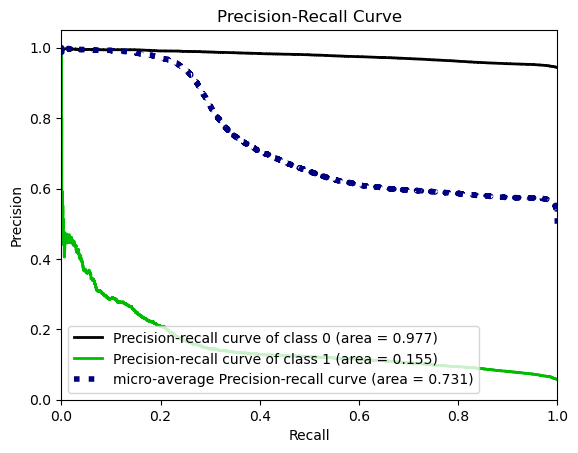

In [167]:
#Using Logistic Regression
lr = LogisticRegression()
model_eval(lr,X_train,y_train,X_test,y_test)

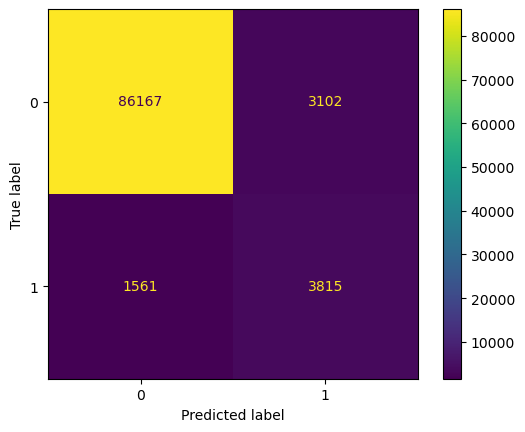

Classification Report: 
               precision    recall  f1-score   support

           0      0.982     0.965     0.974     89269
           1      0.552     0.710     0.621      5376

    accuracy                          0.951     94645
   macro avg      0.767     0.837     0.797     94645
weighted avg      0.958     0.951     0.954     94645



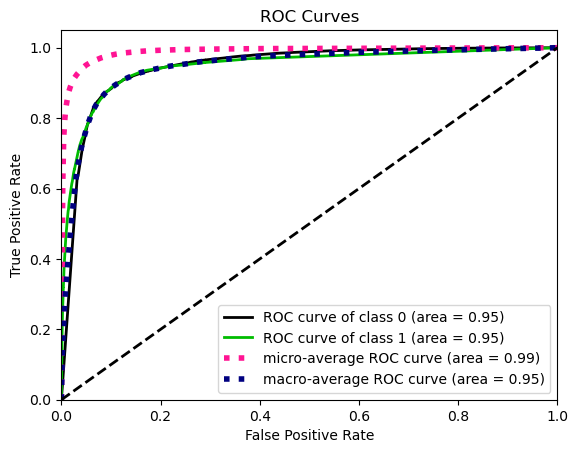

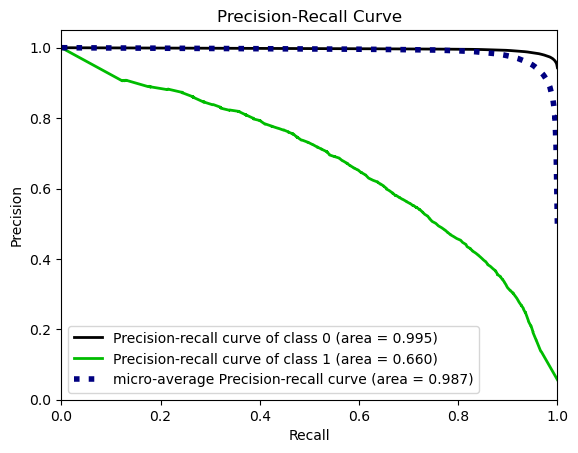

In [170]:
#Using Random Forest Classifier

rf = RandomForestClassifier()
model_eval(rf,X_train,y_train,X_test,y_test)

There is a slight increase in Recall which was previously 79.5 % now 85.1 %. Indeed, there will be a trade-off between Recall and Precission, so I use the scoring on GridScearchCV, which is F1-Score because I try to harmonize the two. It should be recalled that this dataset is imbalanced or unbalanced in the target variable.

In [171]:
#save the best models with pickel
with open('rf_model.pkl', 'wb') as f:
   pickle.dump(rf, f)

# **6. Conclusion**

Of all the stages that we have passed, there are several conclusions that can be drawn from this project:

1. The best model is RandomForestClassifier with a Micro Average PR AUC of 98.7%, Recall of 76%, Precision of 83%
  
  
  
2. Variables that are relevant or influential to the target are:
  * Term
  * RevLineCr
  * Portion_SBA_Bank
  * Is_RetainedJob
  * Disbursement Gross
  * State_rate
  *GrAppv
  * Recssion
  * Sector_rate
  